[(0, 'pred_iter_0'), (100, 'pred_iter_100'), (200, 'pred_iter_200'), (300, 'pred_iter_300'), (400, 'pred_iter_400'), (500, 'pred_iter_500'), (600, 'pred_iter_600'), (700, 'pred_iter_700'), (800, 'pred_iter_800'), (900, 'pred_iter_900'), (1000, 'pred_iter_1000'), (1100, 'pred_iter_1100'), (1200, 'pred_iter_1200'), (1300, 'pred_iter_1300'), (1400, 'pred_iter_1400'), (1500, 'pred_iter_1500'), (1600, 'pred_iter_1600'), (1700, 'pred_iter_1700'), (1800, 'pred_iter_1800'), (1900, 'pred_iter_1900'), (2000, 'pred_iter_2000'), (2100, 'pred_iter_2100'), (2200, 'pred_iter_2200'), (2300, 'pred_iter_2300'), (2400, 'pred_iter_2400'), (2500, 'pred_iter_2500'), (2600, 'pred_iter_2600'), (2700, 'pred_iter_2700'), (2800, 'pred_iter_2800'), (2900, 'pred_iter_2900'), (3000, 'pred_iter_3000'), (3100, 'pred_iter_3100'), (3200, 'pred_iter_3200'), (3300, 'pred_iter_3300'), (3400, 'pred_iter_3400'), (3500, 'pred_iter_3500'), (3600, 'pred_iter_3600'), (3700, 'pred_iter_3700'), (3800, 'pred_iter_3800'), (3900, 'p

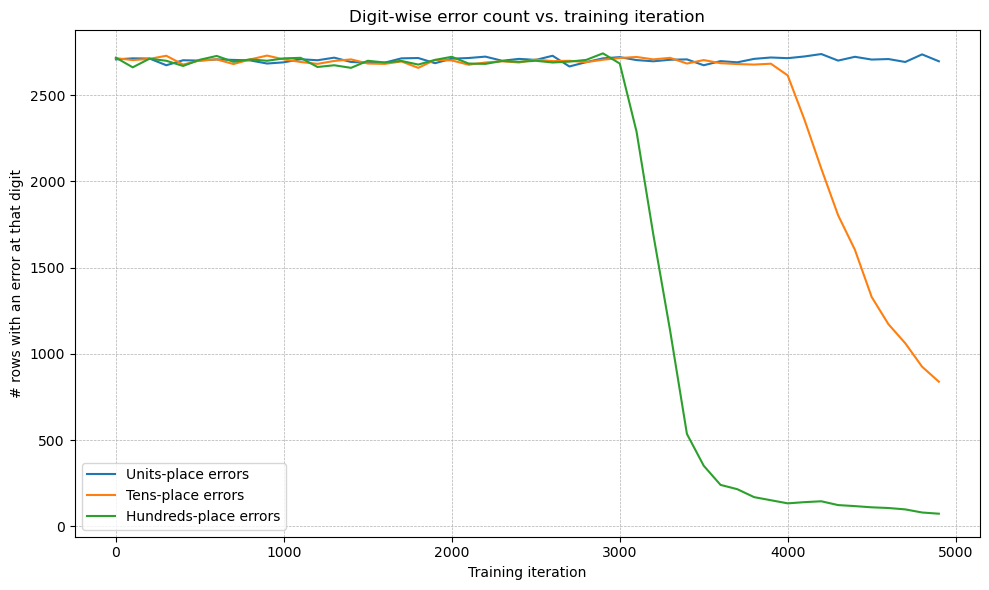

In [12]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_output_wo_leading_digit/plain_out/2_operands_0_to_999_output_wo_leading_digit_plain_20/test_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 5000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    # thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
# plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(0, 'pred_iter_0'), (50, 'pred_iter_50'), (100, 'pred_iter_100'), (150, 'pred_iter_150'), (200, 'pred_iter_200'), (250, 'pred_iter_250'), (300, 'pred_iter_300'), (350, 'pred_iter_350'), (400, 'pred_iter_400'), (450, 'pred_iter_450'), (500, 'pred_iter_500'), (550, 'pred_iter_550'), (600, 'pred_iter_600'), (650, 'pred_iter_650'), (700, 'pred_iter_700'), (750, 'pred_iter_750'), (800, 'pred_iter_800'), (850, 'pred_iter_850'), (900, 'pred_iter_900'), (950, 'pred_iter_950'), (1000, 'pred_iter_1000'), (1050, 'pred_iter_1050'), (1100, 'pred_iter_1100'), (1150, 'pred_iter_1150'), (1200, 'pred_iter_1200'), (1250, 'pred_iter_1250'), (1300, 'pred_iter_1300'), (1350, 'pred_iter_1350'), (1400, 'pred_iter_1400'), (1450, 'pred_iter_1450'), (1500, 'pred_iter_1500')]


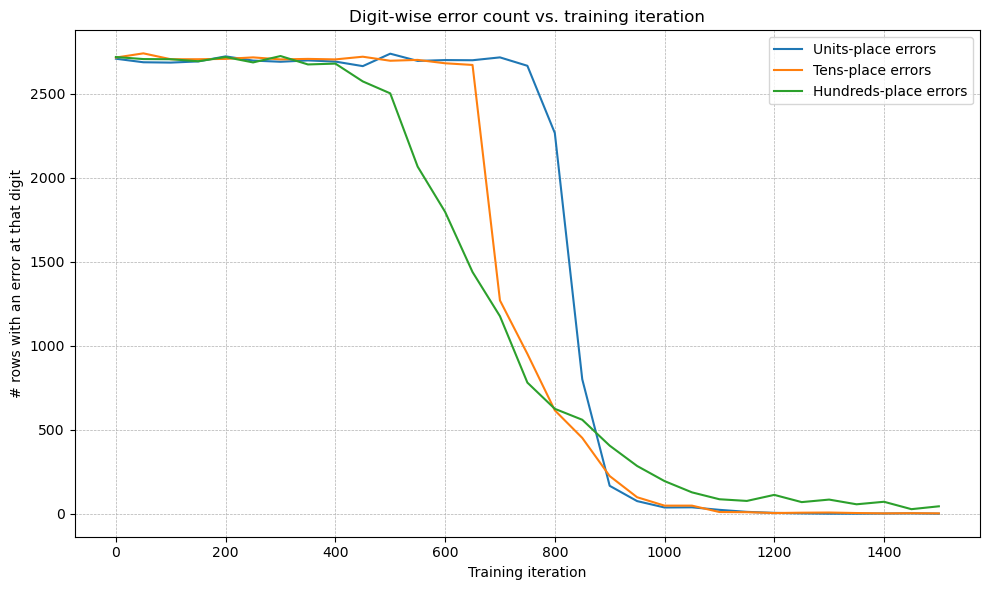

In [10]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_output_wo_leading_digit/plain_out/2_operands_0_to_999_output_wo_leading_digit_plain_19/test_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 1500
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    # thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
# plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(2000, 'pred_iter_2000'), (2050, 'pred_iter_2050'), (2100, 'pred_iter_2100'), (2150, 'pred_iter_2150'), (2200, 'pred_iter_2200'), (2250, 'pred_iter_2250'), (2300, 'pred_iter_2300'), (2350, 'pred_iter_2350'), (2400, 'pred_iter_2400'), (2450, 'pred_iter_2450'), (2500, 'pred_iter_2500'), (2550, 'pred_iter_2550'), (2600, 'pred_iter_2600'), (2650, 'pred_iter_2650'), (2700, 'pred_iter_2700'), (2750, 'pred_iter_2750'), (2800, 'pred_iter_2800'), (2850, 'pred_iter_2850'), (2900, 'pred_iter_2900'), (2950, 'pred_iter_2950'), (3000, 'pred_iter_3000'), (3050, 'pred_iter_3050'), (3100, 'pred_iter_3100'), (3150, 'pred_iter_3150'), (3200, 'pred_iter_3200'), (3250, 'pred_iter_3250'), (3300, 'pred_iter_3300'), (3350, 'pred_iter_3350'), (3400, 'pred_iter_3400'), (3450, 'pred_iter_3450'), (3500, 'pred_iter_3500'), (3550, 'pred_iter_3550'), (3600, 'pred_iter_3600'), (3650, 'pred_iter_3650'), (3700, 'pred_iter_3700'), (3750, 'pred_iter_3750'), (3800, 'pred_iter_3800'), (3850, 'pred_iter_3850'), (3900, 'pre

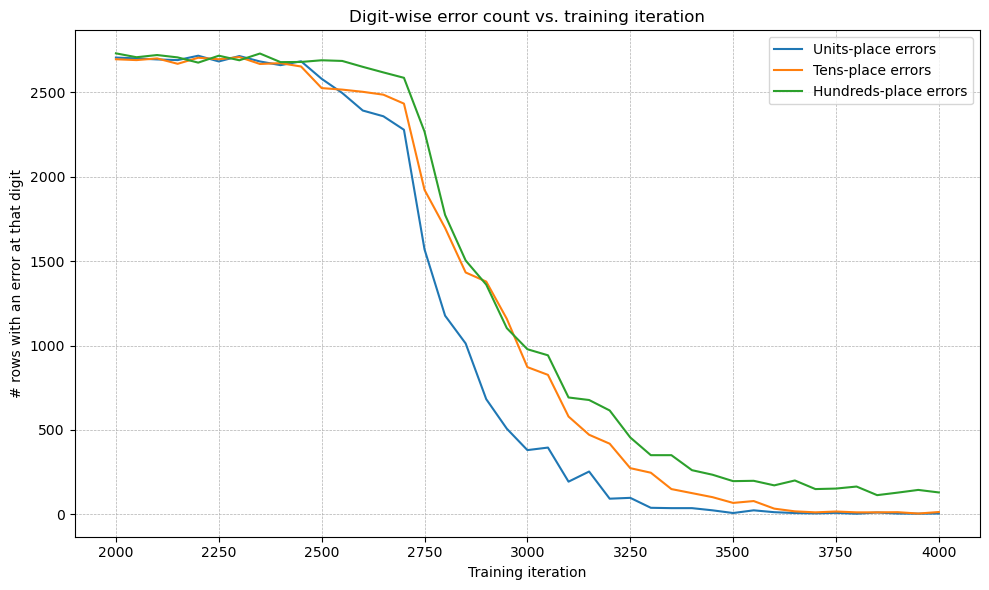

In [14]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_output_wo_leading_digit/plain_out/2_operands_0_to_999_output_wo_leading_digit_plain_21/test_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 4000
MIN_STEPS  = 2000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    # thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
# plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(2000, 'pred_iter_2000'), (2100, 'pred_iter_2100'), (2200, 'pred_iter_2200'), (2300, 'pred_iter_2300'), (2400, 'pred_iter_2400'), (2500, 'pred_iter_2500'), (2600, 'pred_iter_2600'), (2700, 'pred_iter_2700'), (2800, 'pred_iter_2800'), (2900, 'pred_iter_2900'), (3000, 'pred_iter_3000'), (3100, 'pred_iter_3100'), (3200, 'pred_iter_3200'), (3300, 'pred_iter_3300'), (3400, 'pred_iter_3400'), (3500, 'pred_iter_3500'), (3600, 'pred_iter_3600'), (3700, 'pred_iter_3700'), (3800, 'pred_iter_3800'), (3900, 'pred_iter_3900'), (4000, 'pred_iter_4000'), (4100, 'pred_iter_4100'), (4200, 'pred_iter_4200'), (4300, 'pred_iter_4300'), (4400, 'pred_iter_4400'), (4500, 'pred_iter_4500'), (4600, 'pred_iter_4600'), (4700, 'pred_iter_4700'), (4800, 'pred_iter_4800'), (4900, 'pred_iter_4900')]


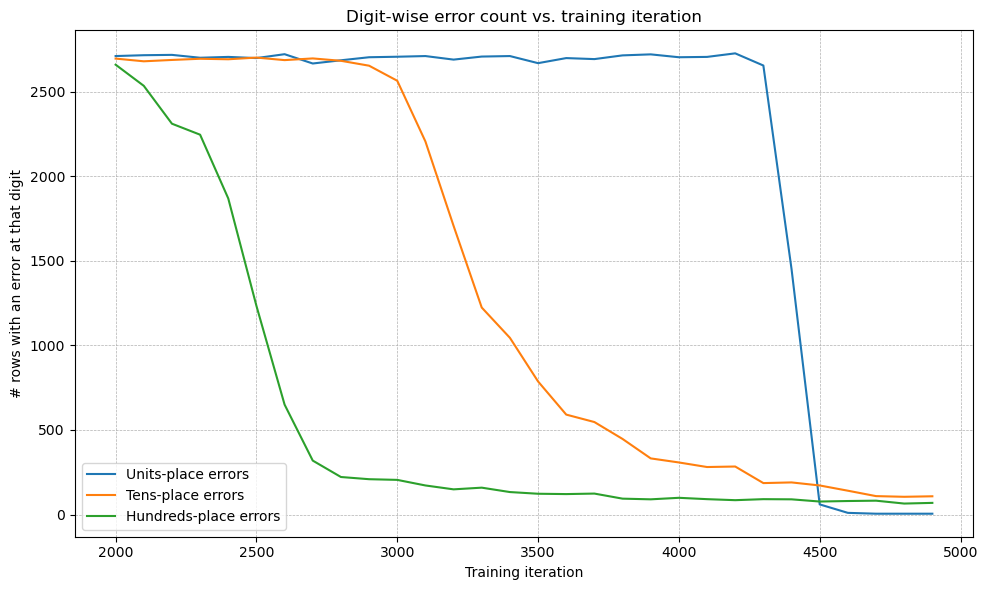

In [15]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_output_wo_leading_digit/plain_out/2_operands_0_to_999_output_wo_leading_digit_plain_22/test_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 5000
MIN_STEPS  = 2000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    # thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
# plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(0, 'pred_iter_0'), (50, 'pred_iter_50'), (100, 'pred_iter_100'), (150, 'pred_iter_150'), (200, 'pred_iter_200'), (250, 'pred_iter_250'), (300, 'pred_iter_300'), (350, 'pred_iter_350'), (400, 'pred_iter_400'), (450, 'pred_iter_450'), (500, 'pred_iter_500'), (550, 'pred_iter_550'), (600, 'pred_iter_600'), (650, 'pred_iter_650'), (700, 'pred_iter_700'), (750, 'pred_iter_750'), (800, 'pred_iter_800'), (850, 'pred_iter_850'), (900, 'pred_iter_900'), (950, 'pred_iter_950'), (1000, 'pred_iter_1000'), (1050, 'pred_iter_1050'), (1100, 'pred_iter_1100'), (1150, 'pred_iter_1150'), (1200, 'pred_iter_1200'), (1250, 'pred_iter_1250'), (1300, 'pred_iter_1300'), (1350, 'pred_iter_1350'), (1400, 'pred_iter_1400'), (1450, 'pred_iter_1450'), (1500, 'pred_iter_1500'), (1550, 'pred_iter_1550'), (1600, 'pred_iter_1600'), (1650, 'pred_iter_1650'), (1700, 'pred_iter_1700'), (1750, 'pred_iter_1750'), (1800, 'pred_iter_1800'), (1850, 'pred_iter_1850'), (1900, 'pred_iter_1900'), (1950, 'pred_iter_1950'), (2000

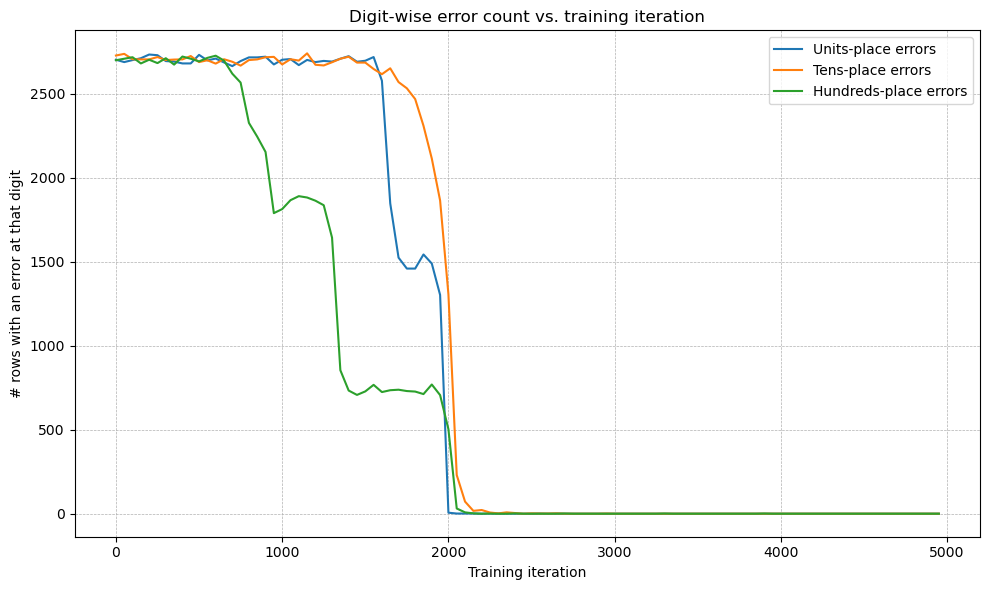

In [9]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_output_wo_leading_digit/reverse_out/2_operands_0_to_999_output_wo_leading_digit_reverse_6/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 5000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    # thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
# plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

[(0, 'pred_iter_0'), (1000, 'pred_iter_1000'), (2000, 'pred_iter_2000'), (3000, 'pred_iter_3000'), (4000, 'pred_iter_4000'), (5000, 'pred_iter_5000'), (6000, 'pred_iter_6000'), (7000, 'pred_iter_7000'), (8000, 'pred_iter_8000'), (9000, 'pred_iter_9000'), (10000, 'pred_iter_10000'), (11000, 'pred_iter_11000'), (12000, 'pred_iter_12000'), (13000, 'pred_iter_13000'), (14000, 'pred_iter_14000')]


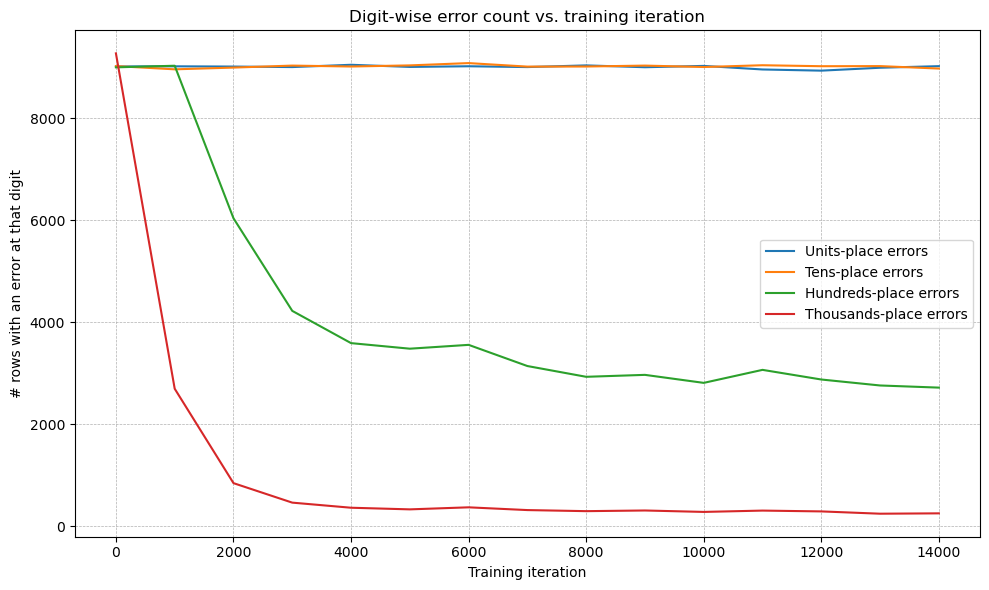

In [7]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 800000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
#!/usr/bin/env python3
"""
diff_histograms.py

Usage:
    python diff_histograms.py input.csv [output.csv]

Reads a CSV with an 'actual' column and columns named like 'pred_iter_8000',
'pred_iter_9000', ... . For each requested iteration (8000..15000 step 1000),
compute diff = actual - prediction, then count how many rows produce each diff
in the integer range -100..100. The script writes a CSV with rows = differences
(-100..100) and columns = iter_8000, iter_9000, ... containing counts.

This script is robust to messy numeric cells such as "17+62" or " 154.0 ".
It will attempt to safely evaluate simple addition/subtraction expressions.
Invalid or missing numeric fields are treated as NaN and skipped.
"""

import sys
import pandas as pd
import numpy as np
import ast
from typing import Union

Input_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/test_reverse_results.csv'
Output_file_path = 'difference_histograms_8000_15000.csv'

# -------------------------
# Safe evaluator for simple arithmetic expressions (only + and - allowed)
# -------------------------
ALLOWED_BINOPS = (ast.Add, ast.Sub)
ALLOWED_UNARYOPS = (ast.UAdd, ast.USub)
ALLOWED_NODES = (ast.Expression, ast.BinOp, ast.UnaryOp, ast.Constant, ast.Num)  # ast.Num for py<3.8

def safe_eval_simple_expr(expr: str) -> Union[int, float, None]:
    """
    Safely evaluate a simple arithmetic expression containing numbers, + and - only.
    Returns numeric value or None if evaluation is not allowed/failed.
    """
    if expr is None:
        return None
    if isinstance(expr, (int, float, np.integer, np.floating)):
        return float(expr)

    s = str(expr).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return None

    try:
        tree = ast.parse(s, mode="eval")
    except Exception:
        return None

    # Validate nodes
    for node in ast.walk(tree):
        if not isinstance(node, ALLOWED_NODES) and not isinstance(node, ast.BinOp) and not isinstance(node, ast.UnaryOp):
            return None
        # If node is BinOp, allow only + and -
        if isinstance(node, ast.BinOp):
            if not isinstance(node.op, ALLOWED_BINOPS):
                return None
        if isinstance(node, ast.UnaryOp):
            if not isinstance(node.op, ALLOWED_UNARYOPS):
                return None

    # Safe evaluate by recursive visitor
    def _eval(node):
        if isinstance(node, ast.Expression):
            return _eval(node.body)
        if isinstance(node, ast.Constant):  # Python 3.8+
            return node.value
        if hasattr(ast, "Num") and isinstance(node, ast.Num):  # older Python
            return node.n
        if isinstance(node, ast.BinOp):
            left = _eval(node.left)
            right = _eval(node.right)
            if left is None or right is None:
                raise ValueError("Invalid operand")
            if isinstance(node.op, ast.Add):
                return left + right
            elif isinstance(node.op, ast.Sub):
                return left - right
            else:
                raise ValueError("Unsupported operator")
        if isinstance(node, ast.UnaryOp):
            operand = _eval(node.operand)
            if isinstance(node.op, ast.UAdd):
                return +operand
            elif isinstance(node.op, ast.USub):
                return -operand
            else:
                raise ValueError("Unsupported unary op")
        raise ValueError("Unsupported AST node")

    try:
        val = _eval(tree)
        # Convert booleans to numbers (False=0 True=1) won't happen likely but be safe:
        if isinstance(val, bool):
            return float(val)
        return float(val)
    except Exception:
        return None

# -------------------------
# Main routine
# -------------------------
def build_histograms(
    infile: str,
    outfile: str = "difference_histograms_8000_15000.csv",
    iter_start: int = 8000,
    iter_end: int = 15000,
    iter_step: int = 1000,
    diff_min: int = -100,
    diff_max: int = 100,
    actual_col_name: str = "actual",
    pred_col_template: str = "pred_iter_{}",
    include_missing_counts: bool = False
):
    df = pd.read_csv(infile, dtype=str)  # read as str to let safe parser handle messy cells

    # normalize column names (strip spaces)
    df.columns = [c.strip() for c in df.columns]

    if actual_col_name not in df.columns:
        raise ValueError(f"Actual column '{actual_col_name}' not found in CSV. Columns: {df.columns.tolist()}")

    iterations = list(range(iter_start, iter_end + 1, iter_step))
    present_iters = []
    for it in iterations:
        cname = pred_col_template.format(it)
        if cname in df.columns:
            present_iters.append((it, cname))
        else:
            # allow alternative naming like pred_iter_8000 without "iter" or variations? For now strictly match.
            # if not found, skip but warn
            print(f"Warning: column '{cname}' not found in CSV; skipping iteration {it}")

    # Prepare index of differences
    diffs = list(range(diff_min, diff_max + 1))
    counts = pd.DataFrame(0, index=diffs, columns=[f"iter_{it}" for (it, _) in present_iters], dtype=int)

    # Optionally keep counters for how many predictions were missing or invalid
    invalid_counts = {f"iter_{it}": 0 for (it, _) in present_iters}
    missing_actual = 0
    total_rows = len(df)

    # Iterate rows
    for idx, row in df.iterrows():
        actual_raw = row[actual_col_name]
        actual_val = safe_eval_simple_expr(actual_raw)
        if actual_val is None:
            missing_actual += 1
            continue
        # use integer diffs (rounded)
        for it, cname in present_iters:
            pred_raw = row[cname]
            pred_val = safe_eval_simple_expr(pred_raw)
            if pred_val is None:
                invalid_counts[f"iter_{it}"] += 1
                continue
            diff = actual_val - pred_val
            # round to nearest integer (you can change this behavior if you prefer floor/trunc)
            diff_int = int(round(diff))
            if diff_int < diff_min or diff_int > diff_max:
                # out of desired range: ignore (if you want, we could collect overflow bins)
                continue
            counts.at[diff_int, f"iter_{it}"] += 1

    # Save output
    counts.index.name = "difference"
    counts.to_csv(outfile)
    print(f"Saved histogram counts to '{outfile}'")
    print(f"Processed {total_rows} rows. Missing actuals: {missing_actual}.")
    print("Invalid/missing predictions per iteration (counts skipped):")
    for k, v in invalid_counts.items():
        print(f"  {k}: {v}")

    # If include_missing_counts True, return an extended DataFrame with two extra rows for out-of-range counts:
    if include_missing_counts:
        # compute out-of-range / missing per iteration
        below = {col: 0 for col in counts.columns}
        above = {col: 0 for col in counts.columns}
        # re-scan to compute these extra bins (cheap for typical CSV sizes)
        for idx, row in df.iterrows():
            actual_val = safe_eval_simple_expr(row[actual_col_name])
            if actual_val is None:
                continue
            for it, cname in present_iters:
                pred_val = safe_eval_simple_expr(row[cname])
                if pred_val is None:
                    continue
                diff_int = int(round(actual_val - pred_val))
                if diff_int < diff_min:
                    below[f"iter_{it}"] += 1
                elif diff_int > diff_max:
                    above[f"iter_{it}"] += 1
        # append these as rows
        counts_extra = counts.copy()
        counts_extra.loc[f"<{diff_min}"] = pd.Series(below)
        counts_extra.loc[f">{diff_max}"] = pd.Series(above)
        counts_extra.to_csv(outfile.replace(".csv", "_with_overflow.csv"))
        print("Also saved counts with overflow bins to:",
              outfile.replace(".csv", "_with_overflow.csv"))
        return counts, counts_extra

    return counts

# -------------------------
# Entry point
# -------------------------
if __name__ == "__main__":

    # call function - by default iter 8000..15000 step 1000, diff range -100..100
    build_histograms(Input_file_path, Output_file_path)


Saved histogram counts to 'difference_histograms_8000_15000.csv'
Processed 10000 rows. Missing actuals: 0.
Invalid/missing predictions per iteration (counts skipped):
  iter_8000: 0
  iter_9000: 0
  iter_10000: 0
  iter_11000: 0
  iter_12000: 0
  iter_13000: 0
  iter_14000: 0


In [9]:
#!/usr/bin/env python3
"""
plot_diff_histograms.py

Usage:
    python plot_diff_histograms.py input.csv [output_dir]

Reads a CSV with a 'difference' column and columns like 'iter_8000', 'iter_9000', ...
Draws:
  - a bar chart (PNG) for each iteration column, saved to output_dir/
  - a combined line plot overlaying all iterations, saved as combined.png

Dependencies:
    pip install pandas matplotlib
"""

import sys
import os
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Input_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/difference_histograms_8000_15000.csv'
Output_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots'

def discover_iter_columns(df: pd.DataFrame, diff_col_name: str = "difference") -> List[str]:
    """Return columns to plot (all columns except the difference column)."""
    return [c for c in df.columns if c != diff_col_name]

def make_output_dir(path: str):
    os.makedirs(path, exist_ok=True)

def plot_single_iteration(diffs: np.ndarray, counts: np.ndarray, iter_name: str, outpath: str):
    """
    Create a single bar chart for one iteration and save to outpath (PNG).
    Uses matplotlib; does not set specific colors so defaults are used.
    """
    plt.figure(figsize=(10, 5))
    # bar plot
    plt.bar(diffs, counts, width=1.0, align="center")
    plt.title(f"Difference distribution — {iter_name}")
    plt.xlabel("difference (actual - predicted)")
    plt.ylabel("count")
    # avoid overcrowding ticks: show every Nth tick
    N = max(1, len(diffs) // 12)
    plt.xticks(diffs[::N], rotation=45)
    plt.grid(axis="y", linestyle=":", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

def plot_combined(diffs: np.ndarray, columns: List[str], matrix: np.ndarray, outpath: str):
    """
    Create a combined line plot with one line per iteration (overlay).
    matrix shape: (len(diffs), len(columns))
    """
    plt.figure(figsize=(11, 6))
    for i, col in enumerate(columns):
        plt.plot(diffs, matrix[:, i], marker="o", linewidth=1, label=col)
    plt.title("Difference distributions (combined)")
    plt.xlabel("difference (actual - predicted)")
    plt.ylabel("count")
    # xticks sampling
    N = max(1, len(diffs) // 12)
    plt.xticks(diffs[::N], rotation=45)
    plt.grid(axis="y", linestyle=":", linewidth=0.5, alpha=0.7)
    plt.legend(ncol=2, fontsize="small")
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

def main(infile: str, outdir: str = "plots"):
    # read CSV
    df = pd.read_csv(infile)
    # normalize column names
    df.columns = [c.strip() for c in df.columns]

    if "difference" not in df.columns:
        raise ValueError("CSV must contain a 'difference' column.")

    # ensure difference column is integer-sorted
    # convert to int (safe)
    df["difference"] = df["difference"].astype(int)
    df = df.sort_values("difference", ascending=True).reset_index(drop=True)

    iter_cols = discover_iter_columns(df, diff_col_name="difference")
    if len(iter_cols) == 0:
        raise ValueError("No iteration columns found (expected columns like 'iter_8000').")

    # convert counts to numeric (fill NaN with 0)
    for c in iter_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    diffs = df["difference"].to_numpy()
    matrix = df[iter_cols].to_numpy()  # shape (n_diff, n_iters)

    make_output_dir(outdir)

    # Create a bar chart per iteration
    for i, col in enumerate(iter_cols):
        outpath = os.path.join(outdir, f"{col}.png")
        counts = matrix[:, i]
        plot_single_iteration(diffs, counts, col, outpath)
        print(f"Saved {outpath}")

    # Combined plot
    combined_path = os.path.join(outdir, "combined_iterations.png")
    plot_combined(diffs, iter_cols, matrix, combined_path)
    print(f"Saved combined plot to {combined_path}")

if __name__ == "__main__":
    
    main(Input_file_path, Output_file_path)


Saved /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots/iter_8000.png
Saved /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots/iter_9000.png
Saved /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots/iter_10000.png
Saved /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots/iter_11000.png
Saved /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/additio

In [10]:
#!/usr/bin/env python3
"""
plot_overall_points.py

Usage:
    python plot_overall_points.py input.csv [output_dir]

Reads a CSV with a 'difference' column and iteration columns (e.g. iter_8000...).
Sums counts across iteration columns and draws a point graph (markers only)
showing the overall distribution (difference -> total count).
Saves summed CSV and PNG to output_dir (default "plots").
"""

import sys
import os
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Input_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/difference_histograms_8000_15000.csv'
Output_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots'


def discover_iter_columns(df: pd.DataFrame, diff_col_name: str = "difference") -> List[str]:
    """Return columns to sum (all columns except the difference column)."""
    return [c for c in df.columns if c != diff_col_name]

def make_output_dir(path: str):
    os.makedirs(path, exist_ok=True)

def plot_points(diffs: np.ndarray, totals: np.ndarray, outpath: str, title: str = "Overall distribution (points)"):
    plt.figure(figsize=(10, 5))
    # marker-only plot (no connecting line)
    plt.plot(diffs, totals, marker='o', linestyle='None')
    plt.xlabel("difference (actual - predicted)")
    plt.ylabel("total count (summed across iterations)")
    plt.title(title)
    # sample xticks so they are readable
    N = max(1, len(diffs) // 12)
    plt.xticks(diffs[::N], rotation=45)
    plt.grid(axis='y', linestyle=':', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

def main(infile: str, outdir: str = "plots", use_columns: List[str] = None):
    df = pd.read_csv(infile)
    df.columns = [c.strip() for c in df.columns]

    if "difference" not in df.columns:
        raise ValueError("CSV must contain a 'difference' column.")

    df["difference"] = df["difference"].astype(int)
    df = df.sort_values("difference").reset_index(drop=True)

    iter_cols = use_columns if use_columns is not None else discover_iter_columns(df, diff_col_name="difference")
    if len(iter_cols) == 0:
        raise ValueError("No iteration columns found to sum.")

    # Convert to numeric and fill NaN with 0
    for c in iter_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    # Sum across the selected columns (row-wise)
    df["total_count"] = df[iter_cols].sum(axis=1)

    make_output_dir(outdir)
    summed_csv = os.path.join(outdir, "summed_counts.csv")
    df[["difference", "total_count"] + iter_cols].to_csv(summed_csv, index=False)
    print(f"Saved summed counts CSV to: {summed_csv}")

    # Plot point graph
    diffs = df["difference"].to_numpy()
    totals = df["total_count"].to_numpy()
    outpng = os.path.join(outdir, "overall_distribution_points.png")
    plot_points(diffs, totals, outpng)
    print(f"Saved point plot to: {outpng}")

if __name__ == "__main__":
    main(Input_file_path, Output_file_path)


Saved summed counts CSV to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots/summed_counts.csv
Saved point plot to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots/overall_distribution_points.png


In [12]:
#!/usr/bin/env python3
"""
fit_normal_to_counts.py

Usage:
    python fit_normal_to_counts.py input.csv [out_dir]

Expects input.csv to contain columns:
    difference,total_count
where 'difference' are integer bin centers and 'total_count' are counts.

Performs a weighted MLE fit of a normal distribution (weights = counts),
prints mu and sigma, saves a plot (points + fitted curve) and writes parameters
to out_dir/fitted_params.txt.
"""

import sys
import os
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

Input_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots/summed_counts.csv'
Output_file_path = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots'


def weighted_normal_fit(xs: np.ndarray, ws: np.ndarray) -> Tuple[float, float]:
    """
    Weighted MLE for a normal distribution:
      mu = sum(w_i * x_i) / sum(w_i)
      sigma^2 = sum(w_i * (x_i - mu)^2) / sum(w_i)     (MLE, population variance)
    Returns (mu, sigma)
    """
    if len(xs) == 0:
        raise ValueError("Empty data")
    wsum = np.sum(ws)
    if wsum <= 0:
        raise ValueError("Sum of weights must be positive")
    mu = float(np.sum(ws * xs) / wsum)
    var = float(np.sum(ws * (xs - mu) ** 2) / wsum)
    sigma = math.sqrt(max(var, 0.0))
    return mu, sigma

def normal_pdf(x: np.ndarray, mu: float, sigma: float) -> np.ndarray:
    """Return normal PDF values for x (vectorized)."""
    if sigma <= 0:
        # degenerate distribution: return zeros except at mu (approx)
        y = np.zeros_like(x, dtype=float)
        # If x equals mu exactly, put a spike (not normalizable as pdf), but we'll return zeros to avoid NaNs
        # Caller should handle sigma==0 separately.
        return y
    coef = 1.0 / (sigma * math.sqrt(2.0 * math.pi))
    z = (x - mu) / sigma
    return coef * np.exp(-0.5 * z * z)

def plot_fit(diffs: np.ndarray, counts: np.ndarray, mu: float, sigma: float, outpath: str):
    """
    Plot point markers of empirical counts and the fitted normal curve scaled to total counts.
    Saves figure to outpath.
    """
    total = counts.sum()
    x_min, x_max = diffs.min(), diffs.max()
    # high-resolution x for smooth curve
    xs_smooth = np.linspace(x_min - 1, x_max + 1, 500)
    pdf_vals = normal_pdf(xs_smooth, mu, sigma)
    # Scale pdf so the area under pdf over dx=1 equals total counts (counts are per-integer bin)
    # i.e., plot_curve = pdf * total * bin_width (bin_width ~1)
    scaled_pdf = pdf_vals * total  # bin width assumed 1

    plt.figure(figsize=(10, 5))
    # empirical points
    plt.plot(diffs, counts, marker='o', linestyle='None', label='empirical counts')
    # fitted curve
    plt.plot(xs_smooth, scaled_pdf, linestyle='-', linewidth=2, label=f'Normal fit (μ={mu:.3f}, σ={sigma:.3f})')
    plt.xlabel('difference (actual - predicted)')
    plt.ylabel('count')
    plt.title('Empirical counts and fitted normal distribution')
    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.legend()
    # make x ticks readable
    N = max(1, len(diffs) // 12)
    plt.xticks(diffs[::N], rotation=45)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

def main(infile: str, outdir: str = "fit_plots"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.read_csv(infile)
    df.columns = [c.strip() for c in df.columns]

    if 'difference' not in df.columns or 'total_count' not in df.columns:
        raise ValueError("CSV must contain 'difference' and 'total_count' columns")

    # ensure numeric and sorted
    df['difference'] = pd.to_numeric(df['difference'], errors='coerce')
    df['total_count'] = pd.to_numeric(df['total_count'], errors='coerce').fillna(0).astype(float)

    df = df.dropna(subset=['difference']).sort_values('difference').reset_index(drop=True)

    diffs = df['difference'].to_numpy(dtype=float)
    counts = df['total_count'].to_numpy(dtype=float)

    # Fit
    mu, sigma = weighted_normal_fit(diffs, counts)

    # Save parameters
    params_path = os.path.join(outdir, "fitted_params.txt")
    with open(params_path, "w") as f:
        f.write(f"mu\t{mu}\n")
        f.write(f"sigma\t{sigma}\n")
        f.write(f"total_count\t{int(counts.sum())}\n")
    print(f"Fitted parameters saved to: {params_path}")
    print(f"mu = {mu:.6f}, sigma = {sigma:.6f}")

    # Plot
    outpng = os.path.join(outdir, "fit_plot.png")
    plot_fit(diffs, counts, mu, sigma, outpng)
    print(f"Plot saved to: {outpng}")

    # Optionally: compute and print log-likelihood of the counts under the fitted normal
    # Treat counts as independent Poisson with mean = total * p(x) where p(x) is probability mass approx
    # Here we approximate p(x) = integral_{x-0.5}^{x+0.5} Normal(mu,sigma) dx
    try:
        from math import erf, sqrt
        def normal_cdf(x, m, s):
            return 0.5 * (1 + erf((x - m) / (s * sqrt(2))))
        total = counts.sum()
        expected = []
        for x in diffs:
            # approx probability for integer bin x
            p = normal_cdf(x + 0.5, mu, sigma) - normal_cdf(x - 0.5, mu, sigma)
            expected.append(total * max(p, 1e-15))
        expected = np.array(expected)
        # Poisson log-likelihood
        # ll = sum( count * log(expected) - expected - log(count!) )
        # we omit log(count!) since it's constant wrt parameters
        with np.errstate(divide='ignore'):
            ll = np.sum(counts * np.log(expected) - expected)
        print(f"Approx. (Poisson) log-likelihood (constant offset omitted): {ll:.3f}")
    except Exception:
        pass

if __name__ == "__main__":
    main(Input_file_path, Output_file_path)


Fitted parameters saved to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots/fitted_params.txt
mu = 1.261444, sigma = 33.600050
Plot saved to: /Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/4_operands_0_to_999_first_phase_change/reverse_out/4_operands_0_to_999_first_phase_change_4/plots/fit_plot.png
Approx. (Poisson) log-likelihood (constant offset omitted): 365218.164


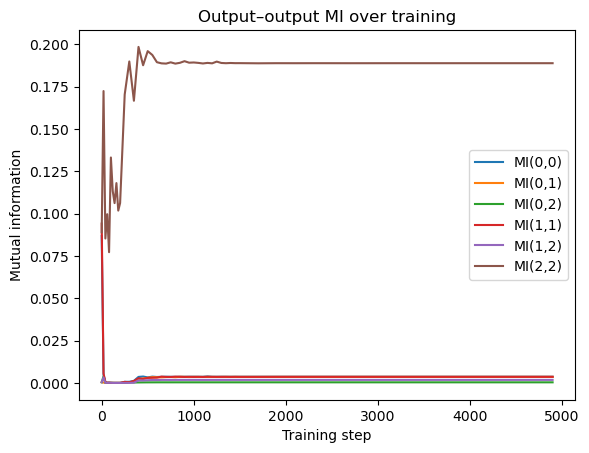

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/2_operands_0_to_999_uniform_gold_by_reading/reverse_out_with_oo_mi_stats/2_operands_0_to_999_uniform_with_oo_mi_stats_3/output_output_mi.csv')
plt.figure()
for (i,j), grp in df.groupby(['i','j']):
    plt.plot(grp['iter'], grp['mi'], label=f"MI({i},{j})")
plt.xlabel("Training step")
plt.ylabel("Mutual information")
plt.legend()
plt.title("Output–output MI over training")
plt.show()


### Input-Output

Normalized Mutual Information

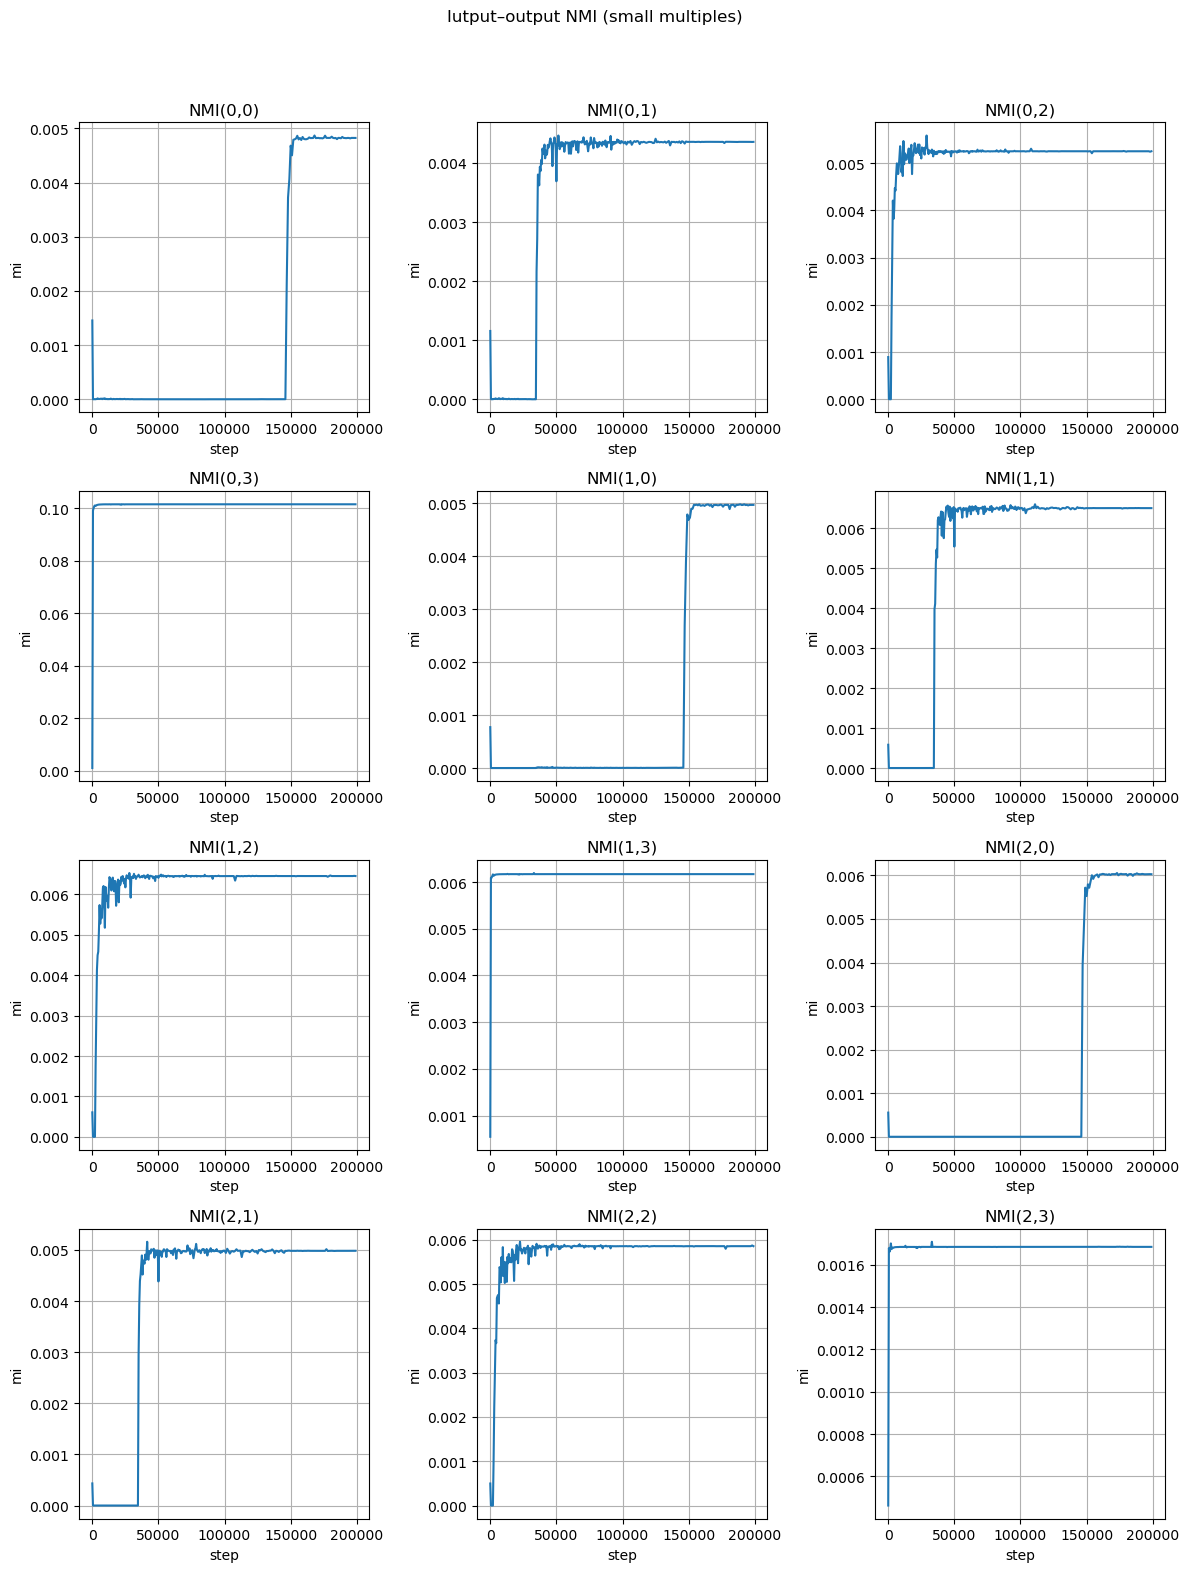

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# --- user‐configurable range ----
MIN_ITER = 0    # first iteration to show
MAX_ITER = 200000 # last iteration to show
# -------------------------------

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/input_output_mi.csv')

# filter the DataFrame down to just the rows you care about
df = df[(df['iter'] >= MIN_ITER) & (df['iter'] <= MAX_ITER)]


pairs = sorted(df[['i','j']].drop_duplicates().values.tolist())
n = len(pairs)
cols = 3
rows = (n + cols - 1)//cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (i,j) in zip(axes, pairs):
    sub = df[(df.i==i)&(df.j==j)]
    ax.plot(sub['iter'], sub['nmi'])
    ax.set_title(f"NMI({i},{j})")
    ax.set_xlabel("step")
    ax.set_ylabel("mi")
    ax.grid(True)

# hide any empty axes
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.suptitle("Iutput–output NMI (small multiples)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


Mutual Information

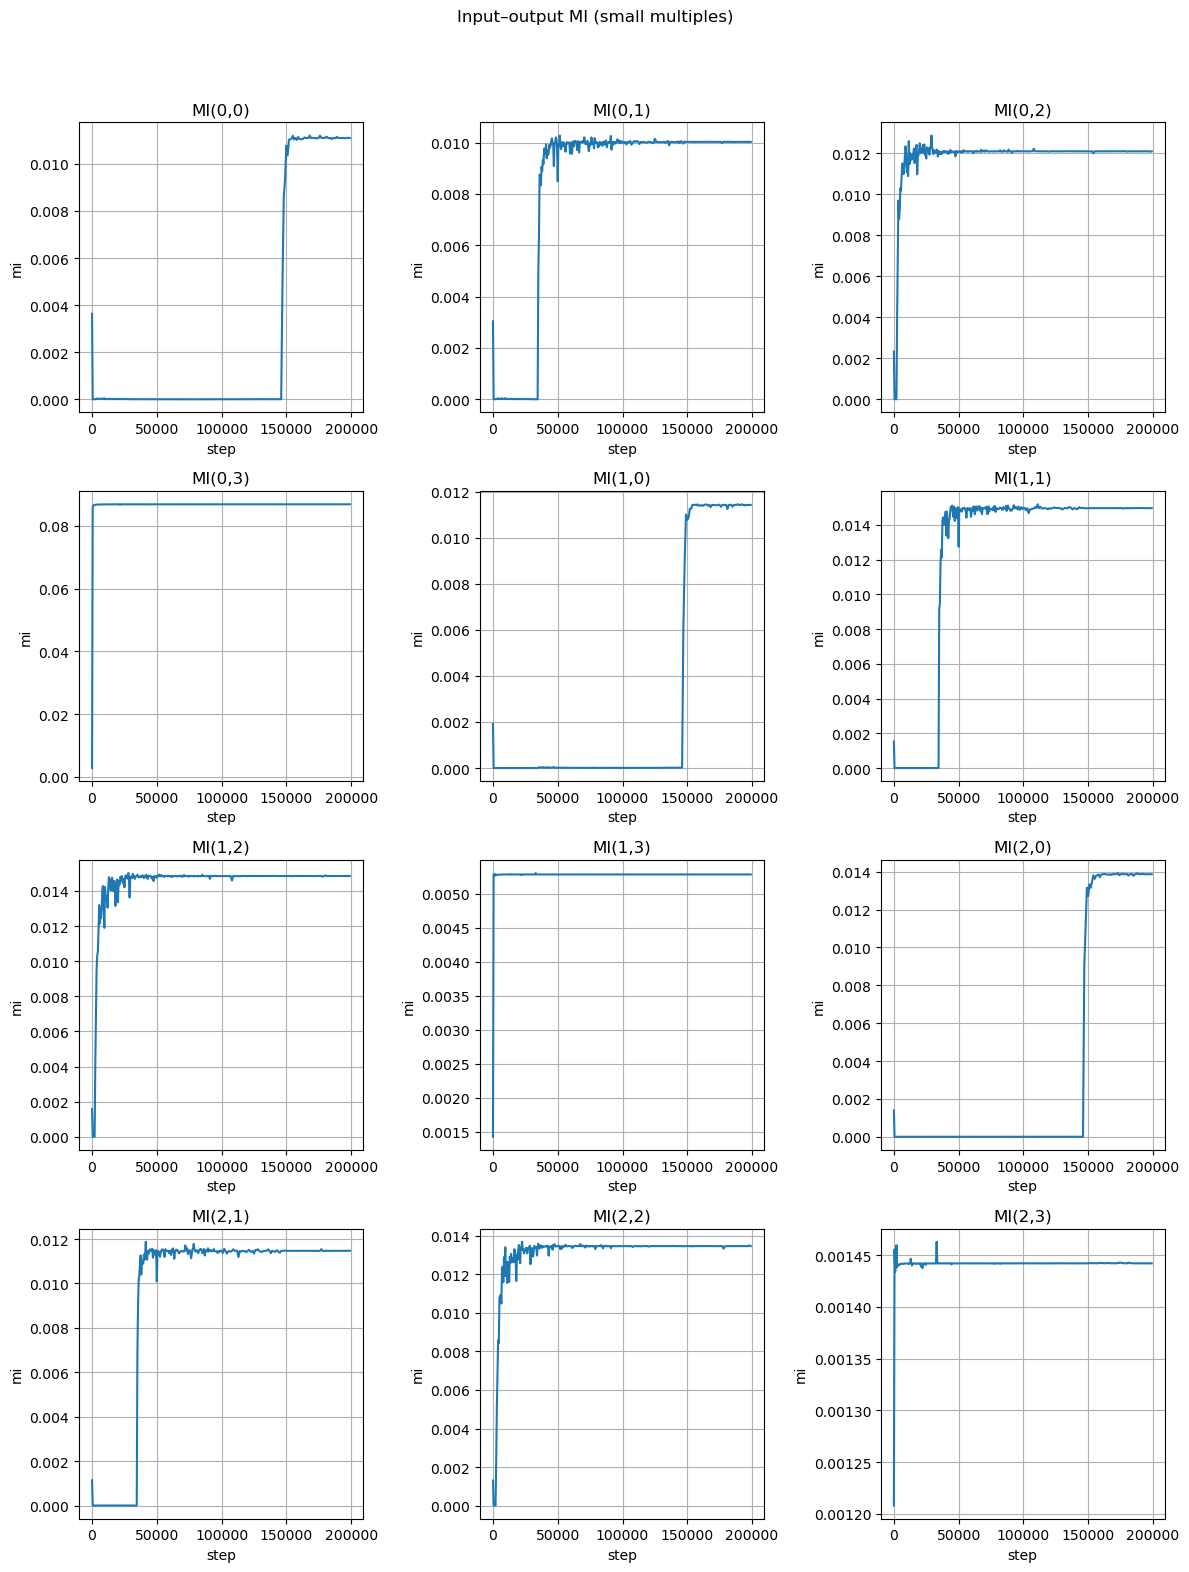

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# --- user‐configurable range ----
MIN_ITER = 0    # first iteration to show
MAX_ITER = 200000 # last iteration to show
# -------------------------------

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/input_output_mi.csv')

# filter the DataFrame down to just the rows you care about
df = df[(df['iter'] >= MIN_ITER) & (df['iter'] <= MAX_ITER)]


pairs = sorted(df[['i','j']].drop_duplicates().values.tolist())
n = len(pairs)
cols = 3
rows = (n + cols - 1)//cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (i,j) in zip(axes, pairs):
    sub = df[(df.i==i)&(df.j==j)]
    ax.plot(sub['iter'], sub['mi'])
    ax.set_title(f"MI({i},{j})")
    ax.set_xlabel("step")
    ax.set_ylabel("mi")
    ax.grid(True)

# hide any empty axes
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.suptitle("Input–output MI (small multiples)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


[(0, 'pred_iter_0'), (200, 'pred_iter_200'), (400, 'pred_iter_400'), (600, 'pred_iter_600'), (800, 'pred_iter_800'), (1000, 'pred_iter_1000'), (1200, 'pred_iter_1200'), (1400, 'pred_iter_1400'), (1600, 'pred_iter_1600'), (1800, 'pred_iter_1800'), (2000, 'pred_iter_2000'), (2200, 'pred_iter_2200'), (2400, 'pred_iter_2400'), (2600, 'pred_iter_2600'), (2800, 'pred_iter_2800'), (3000, 'pred_iter_3000'), (3200, 'pred_iter_3200'), (3400, 'pred_iter_3400'), (3600, 'pred_iter_3600'), (3800, 'pred_iter_3800'), (4000, 'pred_iter_4000'), (4200, 'pred_iter_4200'), (4400, 'pred_iter_4400'), (4600, 'pred_iter_4600'), (4800, 'pred_iter_4800'), (5000, 'pred_iter_5000'), (5200, 'pred_iter_5200'), (5400, 'pred_iter_5400'), (5600, 'pred_iter_5600'), (5800, 'pred_iter_5800'), (6000, 'pred_iter_6000'), (6200, 'pred_iter_6200'), (6400, 'pred_iter_6400'), (6600, 'pred_iter_6600')]


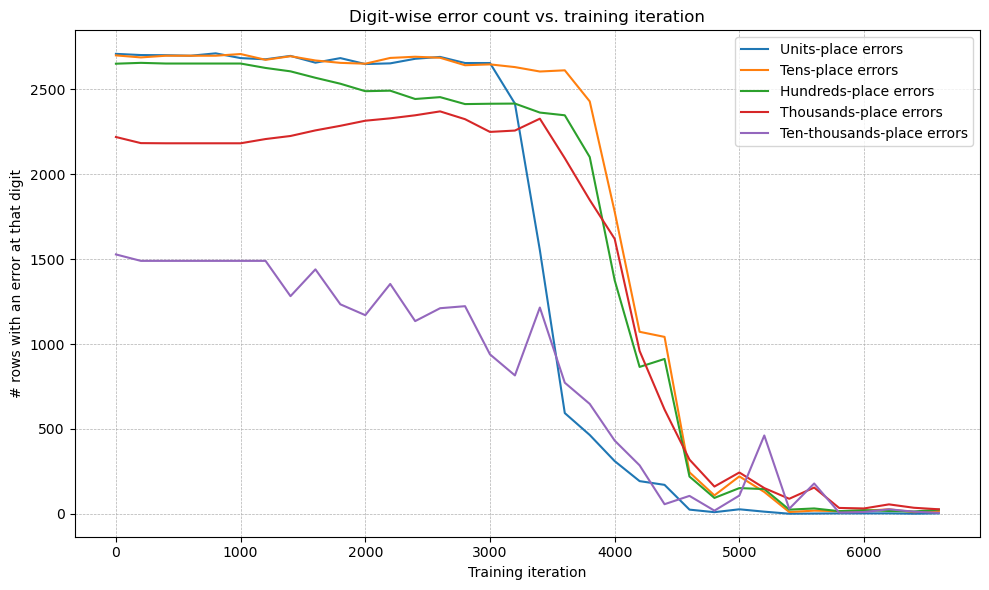

In [2]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/arithmetic_Abacus/cramming-data/add_bucket_20_20_reverse_all_pad_00_depthrec_16_1_TBPTT_1024_batch_size_512_mask_before_equals_true_start_emb_abacus_attn_emb_nope_run_1/test_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 400000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])
    ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
plt.plot(iterations, thousands, label="Thousands-place errors")
plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_44609/3492296703.py:6: DtypeWarning: Columns (4,6,9,10,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  err_df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')


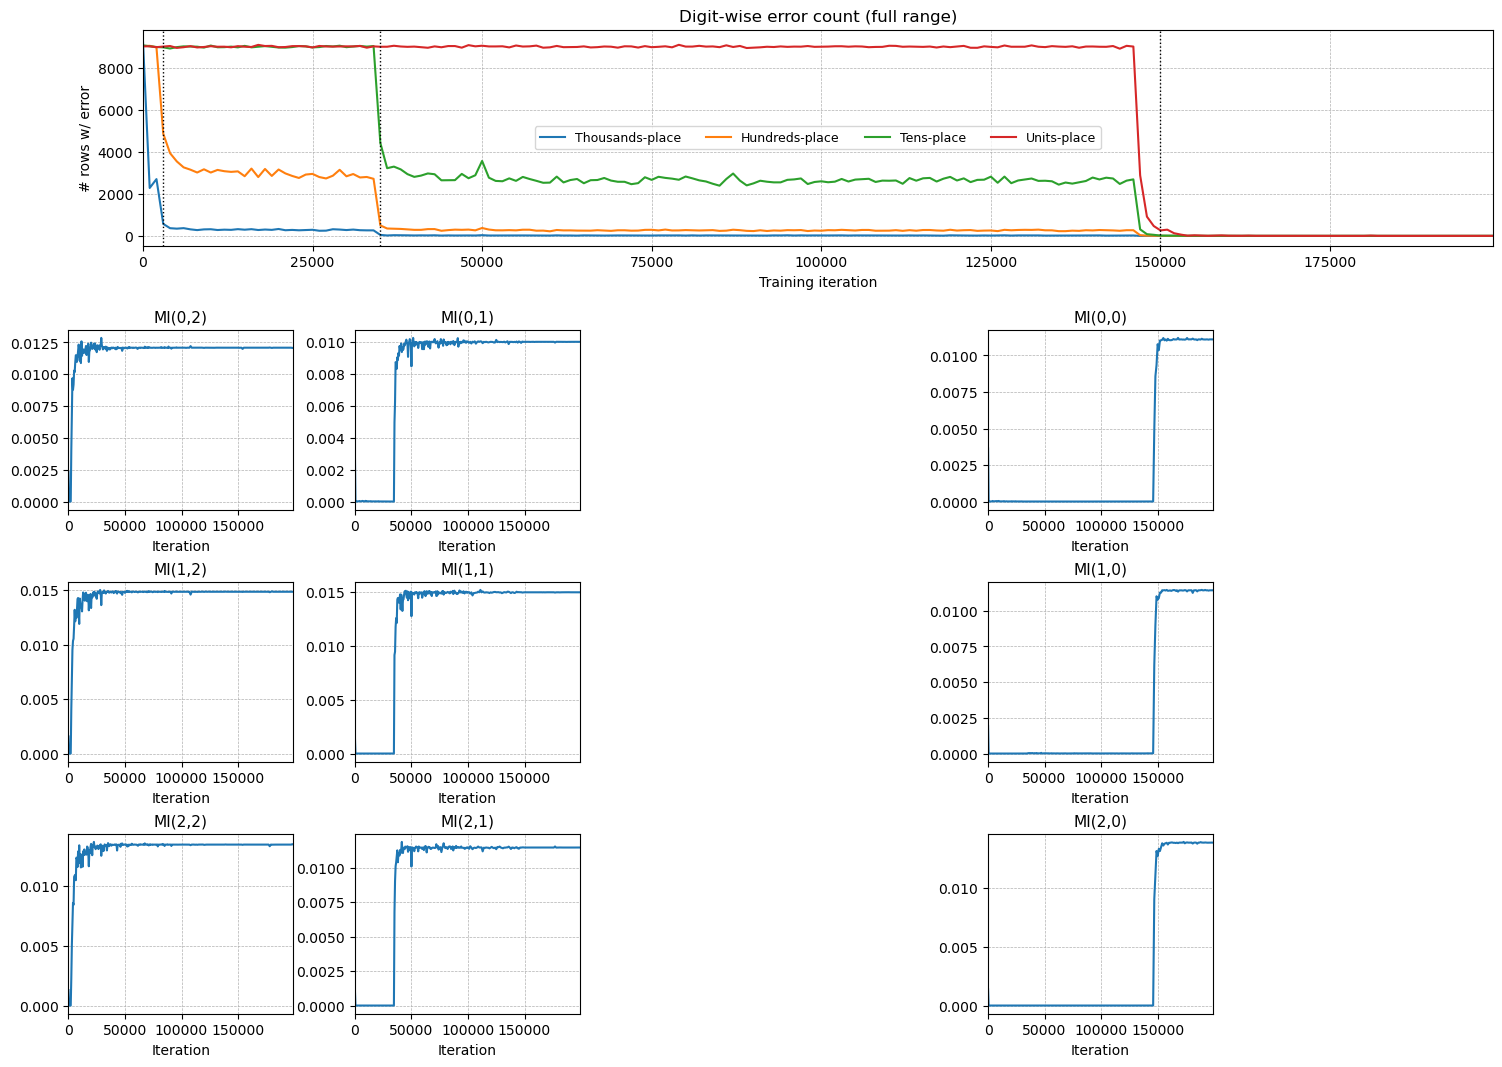

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# ── 1) Load data ──
mi_df  = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/input_output_mi.csv')
err_df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')

# ── 2) Precompute digit‑error counts ──
iterations, units, tens, hundreds, thousands = [], [], [], [], []
for step, colname in pred_cols:
    iterations.append(step)
    stats = digit_error_tally(err_df[ACTUAL_COL], err_df[colname])
    units.append(stats['units'])
    tens.append(stats['tens'])
    hundreds.append(stats['hundreds'])
    thousands.append(stats['thousands'])

# ── 3) Phase centers & max iter ──
phase_centers1 = [3_000, 35_000, 150_000]
Xmax = max(iterations)

# ── 4) Make the figure ──
fig = plt.figure(figsize=(15, 12))

# 4a) Digit‑wise error plot at the very top
err_ax = fig.add_axes([0.05, 0.80, 0.90, 0.18])  # y0=0.80, h=0.18 → covers [0.80–0.98]
err_ax.plot(iterations, thousands, label="Thousands‑place")
err_ax.plot(iterations, hundreds,  label="Hundreds‑place")
err_ax.plot(iterations, tens,      label="Tens‑place")
err_ax.plot(iterations, units,     label="Units‑place")
err_ax.set_xlim(0, Xmax)
err_ax.set_xlabel("Training iteration")
err_ax.set_ylabel("# rows w/ error")
err_ax.set_title("Digit‑wise error count (full range)")
err_ax.legend(ncol=4, fontsize=9)
err_ax.grid(True, linestyle='--', linewidth=0.5)
for c in phase_centers1:
    err_ax.axvline(c, color='k', linestyle=':', linewidth=1)

# ── 5) Square MI panels below ──
W = H = 0.15           # 15% width & height for squares
VSPACE  = 0.06         # larger vertical gap between MI rows
top_pad = 0.58         # start MI grid at y0=0.58 → top row peaks at 0.73

col_to_j = {0:2, 1:1, 2:0}

phase_centers2 = [15_000, 53_000, 137_000]
for col, center in enumerate(phase_centers2):
    j      = col_to_j[col]
    c_frac = center / Xmax
    left   = c_frac - W/2

    for i in [0,1,2]:
        bottom = top_pad - i*(H + VSPACE)
        ax     = fig.add_axes([left, bottom, W, H])
        sub = mi_df[(mi_df.i == i) & (mi_df.j == j)]
        ax.plot(sub['iter'], sub['mi'], lw=1.5)
        ax.set_xlim(0, Xmax)
        ax.set_title(f"MI({i},{j})", fontsize=11)
        ax.set_xlabel("Iteration")
        ax.grid(True, linestyle='--', linewidth=0.5)
        # if col>0:
        #     ax.set_yticklabels([])

plt.show()


/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_44609/686454677.py:6: DtypeWarning: Columns (4,6,9,10,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  err_df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')


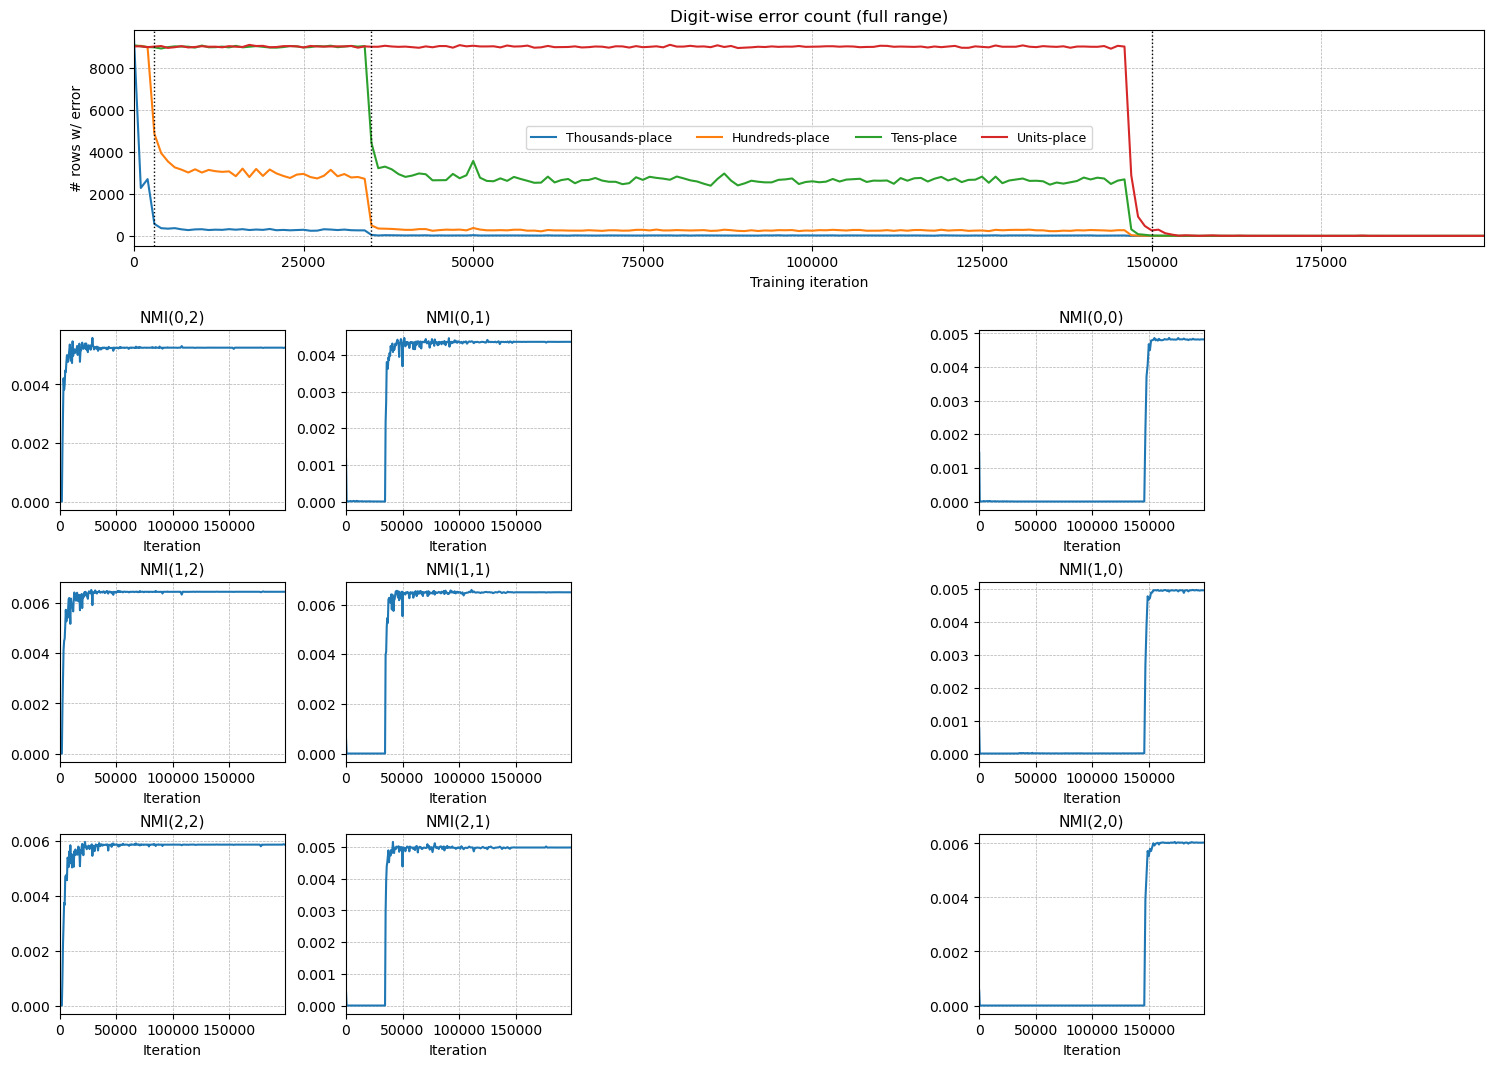

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# ── 1) Load data ──
mi_df  = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/input_output_mi.csv')
err_df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')

# ── 2) Precompute digit‑error counts ──
iterations, units, tens, hundreds, thousands = [], [], [], [], []
for step, colname in pred_cols:
    iterations.append(step)
    stats = digit_error_tally(err_df[ACTUAL_COL], err_df[colname])
    units.append(stats['units'])
    tens.append(stats['tens'])
    hundreds.append(stats['hundreds'])
    thousands.append(stats['thousands'])

# ── 3) Phase centers & max iter ──
phase_centers1 = [3_000, 35_000, 150_000]
Xmax = max(iterations)

# ── 4) Make the figure ──
fig = plt.figure(figsize=(15, 12))

# 4a) Digit‑wise error plot at the very top
err_ax = fig.add_axes([0.05, 0.80, 0.90, 0.18])  # y0=0.80, h=0.18 → covers [0.80–0.98]
err_ax.plot(iterations, thousands, label="Thousands‑place")
err_ax.plot(iterations, hundreds,  label="Hundreds‑place")
err_ax.plot(iterations, tens,      label="Tens‑place")
err_ax.plot(iterations, units,     label="Units‑place")
err_ax.set_xlim(0, Xmax)
err_ax.set_xlabel("Training iteration")
err_ax.set_ylabel("# rows w/ error")
err_ax.set_title("Digit‑wise error count (full range)")
err_ax.legend(ncol=4, fontsize=9)
err_ax.grid(True, linestyle='--', linewidth=0.5)
for c in phase_centers1:
    err_ax.axvline(c, color='k', linestyle=':', linewidth=1)

# ── 5) Square MI panels below ──
W = H = 0.15           # 15% width & height for squares
VSPACE  = 0.06         # larger vertical gap between MI rows
top_pad = 0.58         # start MI grid at y0=0.58 → top row peaks at 0.73

col_to_j = {0:2, 1:1, 2:0}

phase_centers2 = [15_000, 53_000, 137_000]
for col, center in enumerate(phase_centers2):
    j      = col_to_j[col]
    c_frac = center / Xmax
    left   = c_frac - W/2

    for i in [0,1,2]:
        bottom = top_pad - i*(H + VSPACE)
        ax     = fig.add_axes([left, bottom, W, H])
        sub = mi_df[(mi_df.i == i) & (mi_df.j == j)]
        ax.plot(sub['iter'], sub['nmi'], lw=1.5)
        ax.set_xlim(0, Xmax)
        ax.set_title(f"NMI({i},{j})", fontsize=11)
        ax.set_xlabel("Iteration")
        ax.grid(True, linestyle='--', linewidth=0.5)
        # if col>0:
        #     ax.set_yticklabels([])

plt.show()


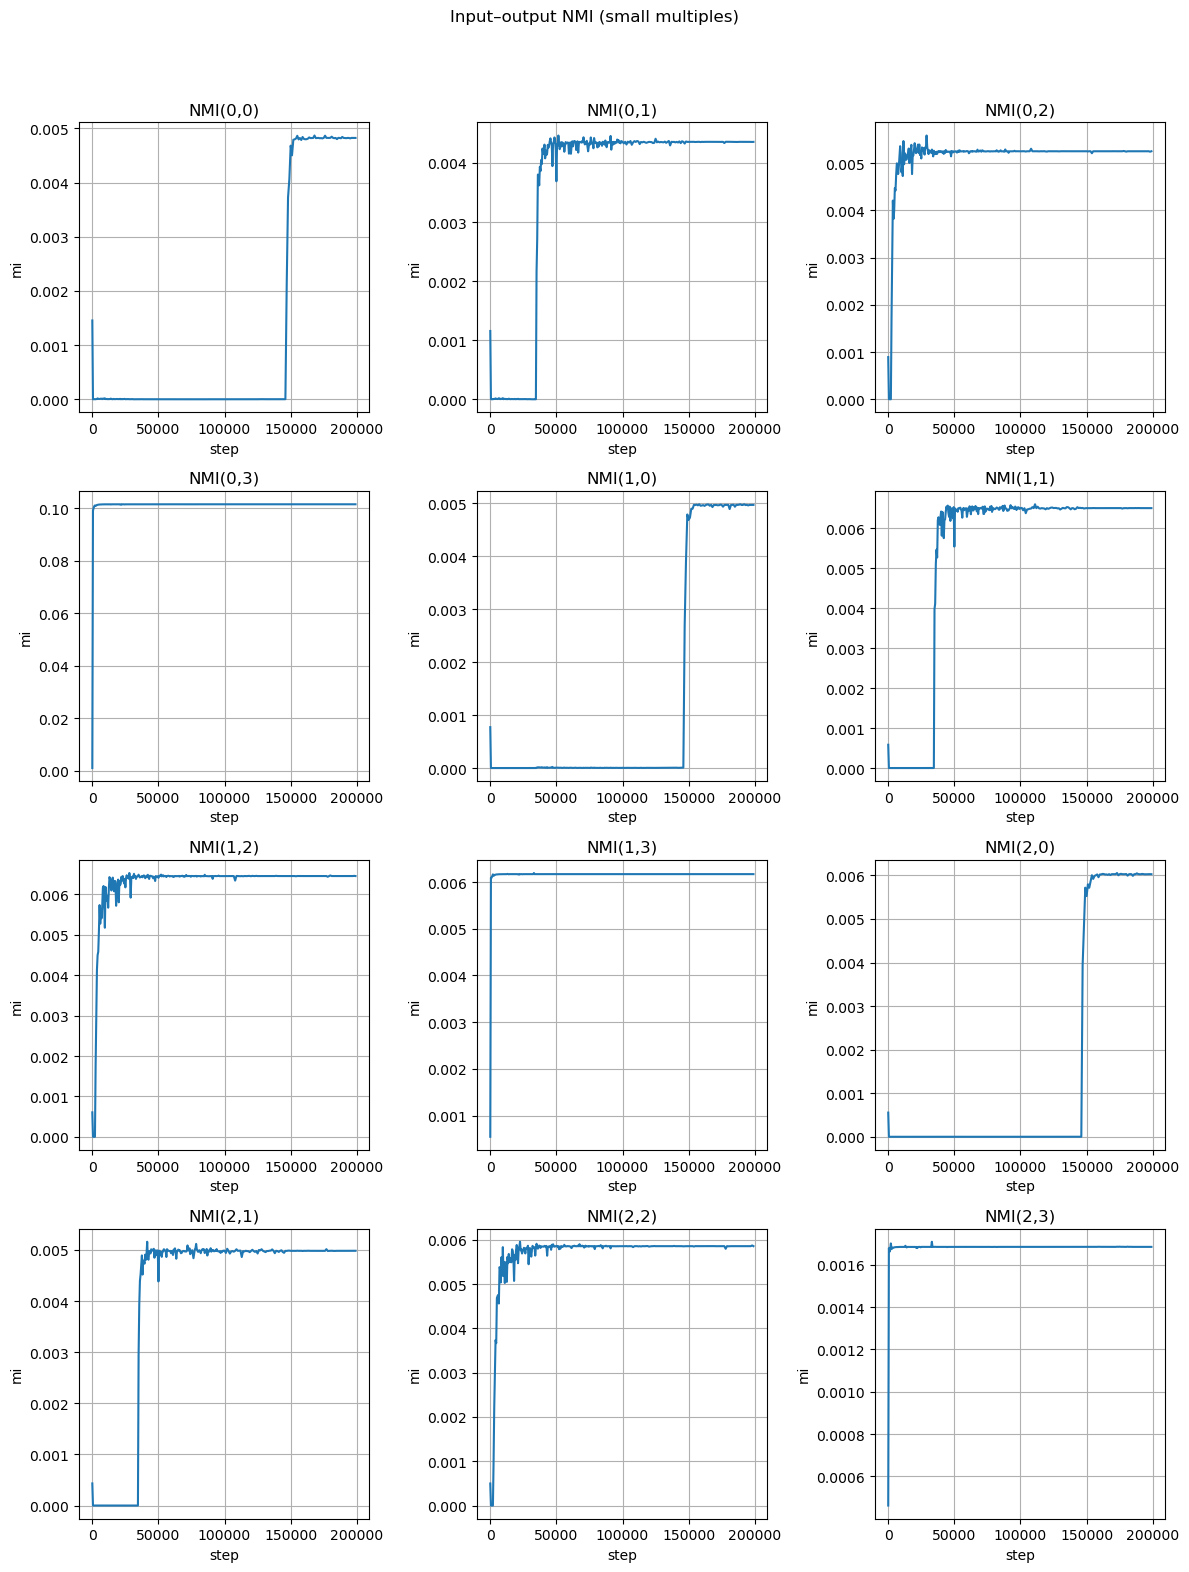

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# --- user‐configurable range ----
MIN_ITER = 0    # first iteration to show
MAX_ITER = 200000 # last iteration to show
# -------------------------------

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/input_output_mi.csv')

# filter the DataFrame down to just the rows you care about
df = df[(df['iter'] >= MIN_ITER) & (df['iter'] <= MAX_ITER)]


pairs = sorted(df[['i','j']].drop_duplicates().values.tolist())
n = len(pairs)
cols = 3
rows = (n + cols - 1)//cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (i,j) in zip(axes, pairs):
    sub = df[(df.i==i)&(df.j==j)]
    ax.plot(sub['iter'], sub['nmi'])
    ax.set_title(f"NMI({i},{j})")
    ax.set_xlabel("step")
    ax.set_ylabel("mi")
    ax.grid(True)

# hide any empty axes
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.suptitle("Input–output NMI (small multiples)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


### Output-output

Normalized Mutual Information

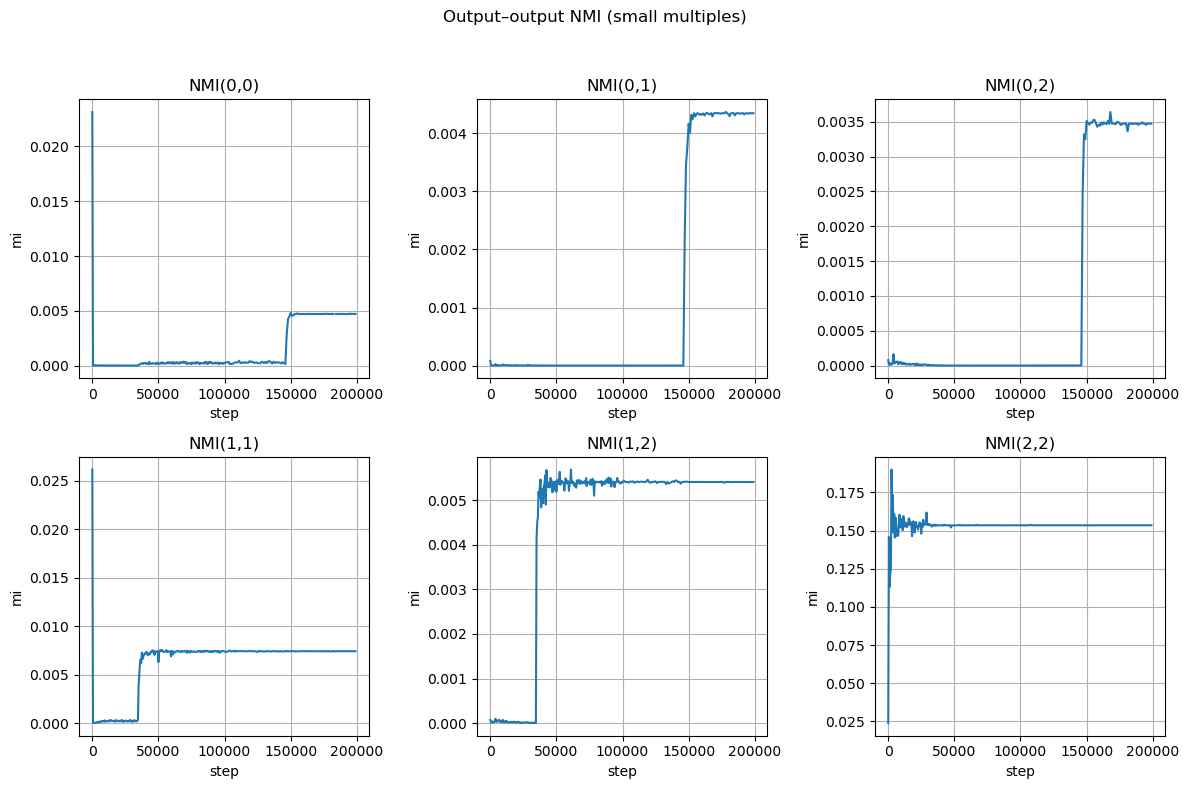

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# --- user‐configurable range ----
MIN_ITER = 0    # first iteration to show
MAX_ITER = 200000 # last iteration to show
# -------------------------------

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/output_output_mi.csv')

# filter the DataFrame down to just the rows you care about
df = df[(df['iter'] >= MIN_ITER) & (df['iter'] <= MAX_ITER)]


pairs = sorted(df[['i','j']].drop_duplicates().values.tolist())
n = len(pairs)
cols = 3
rows = (n + cols - 1)//cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (i,j) in zip(axes, pairs):
    sub = df[(df.i==i)&(df.j==j)]
    ax.plot(sub['iter'], sub['nmi'])
    ax.set_title(f"NMI({i},{j})")
    ax.set_xlabel("step")
    ax.set_ylabel("mi")
    ax.grid(True)

# hide any empty axes
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.suptitle("Output–output NMI (small multiples)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


Mutual Information

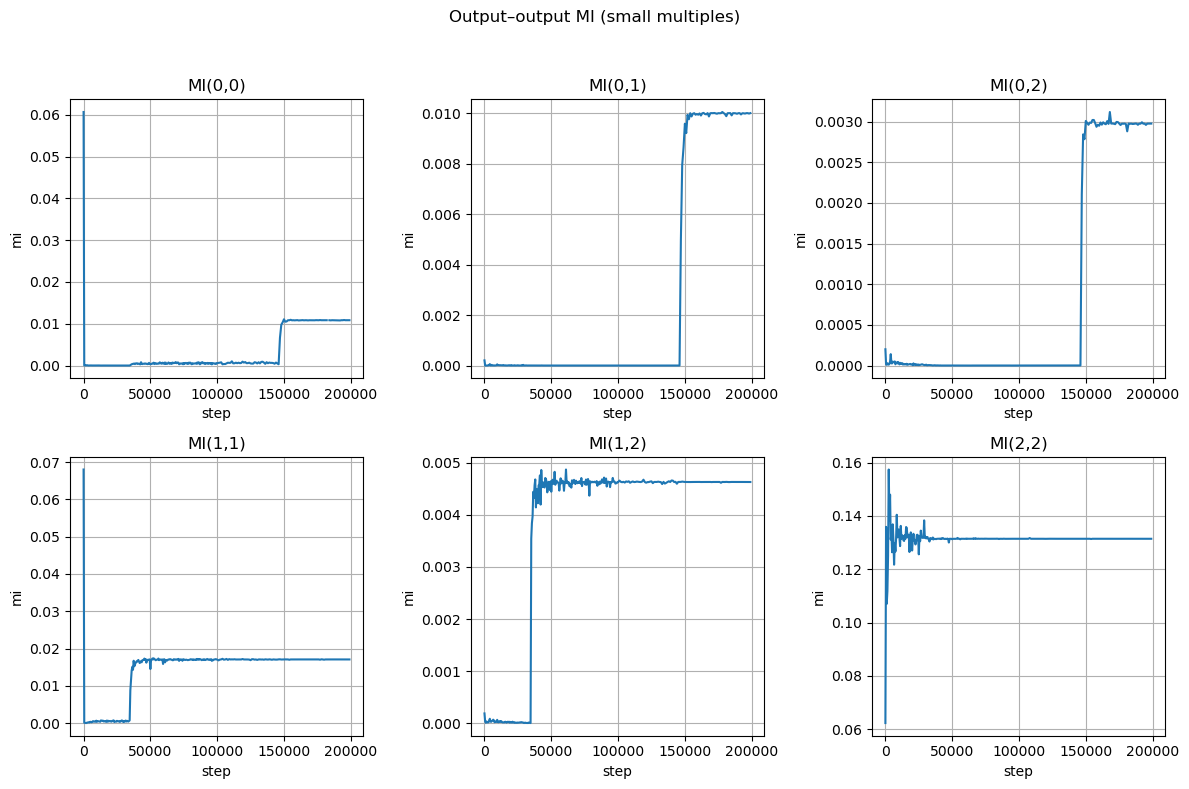

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# --- user‐configurable range ----
MIN_ITER = 0    # first iteration to show
MAX_ITER = 200000 # last iteration to show
# -------------------------------

df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/output_output_mi.csv')

# filter the DataFrame down to just the rows you care about
df = df[(df['iter'] >= MIN_ITER) & (df['iter'] <= MAX_ITER)]


pairs = sorted(df[['i','j']].drop_duplicates().values.tolist())
n = len(pairs)
cols = 3
rows = (n + cols - 1)//cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axes = axes.flatten()

for ax, (i,j) in zip(axes, pairs):
    sub = df[(df.i==i)&(df.j==j)]
    ax.plot(sub['iter'], sub['mi'])
    ax.set_title(f"MI({i},{j})")
    ax.set_xlabel("step")
    ax.set_ylabel("mi")
    ax.grid(True)

# hide any empty axes
for ax in axes[len(pairs):]:
    ax.set_visible(False)

fig.suptitle("Output–output MI (small multiples)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_10602/2940711082.py:28: DtypeWarning: Columns (3,5,6,14,15,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


[(0, 'pred_iter_0'), (2000, 'pred_iter_2000'), (4000, 'pred_iter_4000'), (6000, 'pred_iter_6000'), (8000, 'pred_iter_8000'), (10000, 'pred_iter_10000'), (12000, 'pred_iter_12000'), (14000, 'pred_iter_14000'), (16000, 'pred_iter_16000'), (18000, 'pred_iter_18000'), (20000, 'pred_iter_20000'), (22000, 'pred_iter_22000'), (24000, 'pred_iter_24000'), (26000, 'pred_iter_26000'), (28000, 'pred_iter_28000'), (30000, 'pred_iter_30000'), (32000, 'pred_iter_32000'), (34000, 'pred_iter_34000'), (36000, 'pred_iter_36000'), (38000, 'pred_iter_38000'), (40000, 'pred_iter_40000'), (42000, 'pred_iter_42000'), (44000, 'pred_iter_44000'), (46000, 'pred_iter_46000'), (48000, 'pred_iter_48000'), (50000, 'pred_iter_50000'), (52000, 'pred_iter_52000'), (54000, 'pred_iter_54000'), (56000, 'pred_iter_56000'), (58000, 'pred_iter_58000'), (60000, 'pred_iter_60000'), (62000, 'pred_iter_62000'), (64000, 'pred_iter_64000'), (66000, 'pred_iter_66000'), (68000, 'pred_iter_68000'), (70000, 'pred_iter_70000'), (72000,

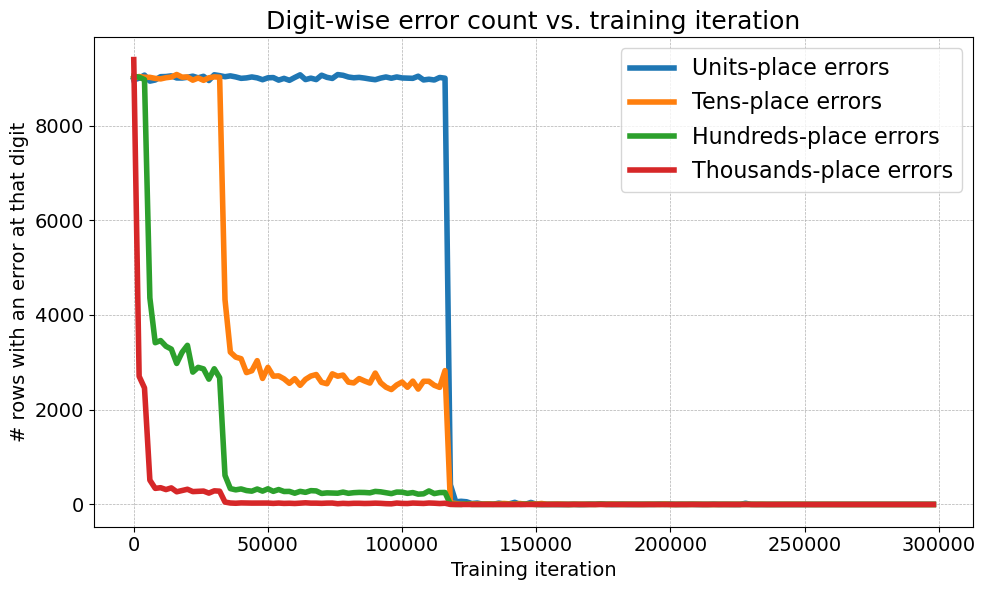

In [28]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rcParams.update({
    "lines.linewidth": 4,        # default line thickness
    "axes.titlesize":   18,      # title font size
    "axes.labelsize":   14,      # x/y label font size
    "xtick.labelsize":  14,      # x‑tick label size
    "ytick.labelsize":  14,      # y‑tick label size
    "legend.fontsize":  16,      # legend text size
})


# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-xzhao468@wisc.edu/My Drive/addition/4_operands_0_to_999_addition_reversed/out/4_operands_0_to_999_addition_reversed_300K_iter/4_operands_0_to_999_10K_test_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 300000
MIN_STEPS  = 0
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS and step >= MIN_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_44609/2402289181.py:8: DtypeWarning: Columns (4,6,9,10,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')


Iteration	Avg Abs Error
0		12579.7223
1000		275.0136
2000		274.1123
3000		70.3030
4000		44.4308
5000		36.8613
6000		35.8032
7000		32.5568
8000		32.6670
9000		32.4033
10000		30.7748
11000		31.7859
12000		30.3713
13000		29.8202
14000		28.9055
15000		28.8691
16000		30.9199
17000		27.6839
18000		31.5404
19000		28.7293
20000		29.5334
21000		29.2991
22000		28.1897
23000		27.9544
24000		28.3699
25000		28.9753
26000		27.0292
27000		27.5841
28000		28.8816
29000		31.3338
30000		27.7766
31000		28.5524
32000		26.6738
33000		27.7388
34000		27.7521
35000		4.9780
36000		3.6191
37000		3.4625
38000		3.2697
39000		3.1554
40000		2.9795
41000		2.8193
42000		3.2121
43000		3.2831
44000		2.9151
45000		2.8120
46000		2.8331
47000		3.0647
48000		2.7252
49000		2.8575
50000		3.6842
51000		2.6903
52000		2.7963
53000		2.7882
54000		2.7598
55000		2.6712
56000		2.9488
57000		2.7225
58000		2.6756
59000		2.6397
60000		2.7804
61000		2.9857
62000		2.6628
63000		2.6867
64000		2.6766
65000		2.7533
66000		2.7090
67000		2.75

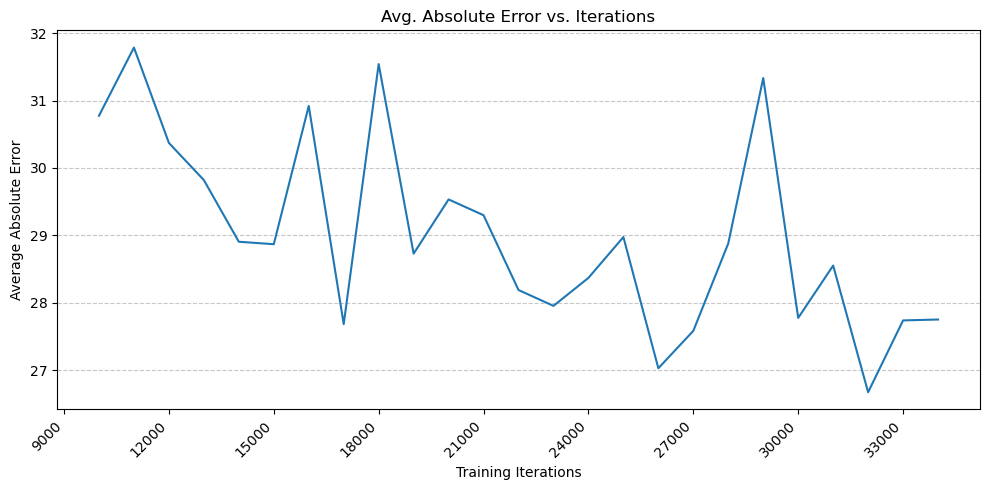

/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_44609/2402289181.py:99: DtypeWarning: Columns (4,6,9,10,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


[(0, 'pred_iter_0'), (1000, 'pred_iter_1000'), (2000, 'pred_iter_2000'), (3000, 'pred_iter_3000'), (4000, 'pred_iter_4000'), (5000, 'pred_iter_5000'), (6000, 'pred_iter_6000'), (7000, 'pred_iter_7000'), (8000, 'pred_iter_8000'), (9000, 'pred_iter_9000'), (10000, 'pred_iter_10000'), (11000, 'pred_iter_11000'), (12000, 'pred_iter_12000'), (13000, 'pred_iter_13000'), (14000, 'pred_iter_14000'), (15000, 'pred_iter_15000'), (16000, 'pred_iter_16000'), (17000, 'pred_iter_17000'), (18000, 'pred_iter_18000'), (19000, 'pred_iter_19000'), (20000, 'pred_iter_20000'), (21000, 'pred_iter_21000'), (22000, 'pred_iter_22000'), (23000, 'pred_iter_23000'), (24000, 'pred_iter_24000'), (25000, 'pred_iter_25000'), (26000, 'pred_iter_26000'), (27000, 'pred_iter_27000'), (28000, 'pred_iter_28000'), (29000, 'pred_iter_29000'), (30000, 'pred_iter_30000'), (31000, 'pred_iter_31000'), (32000, 'pred_iter_32000'), (33000, 'pred_iter_33000'), (34000, 'pred_iter_34000'), (35000, 'pred_iter_35000'), (36000, 'pred_ite

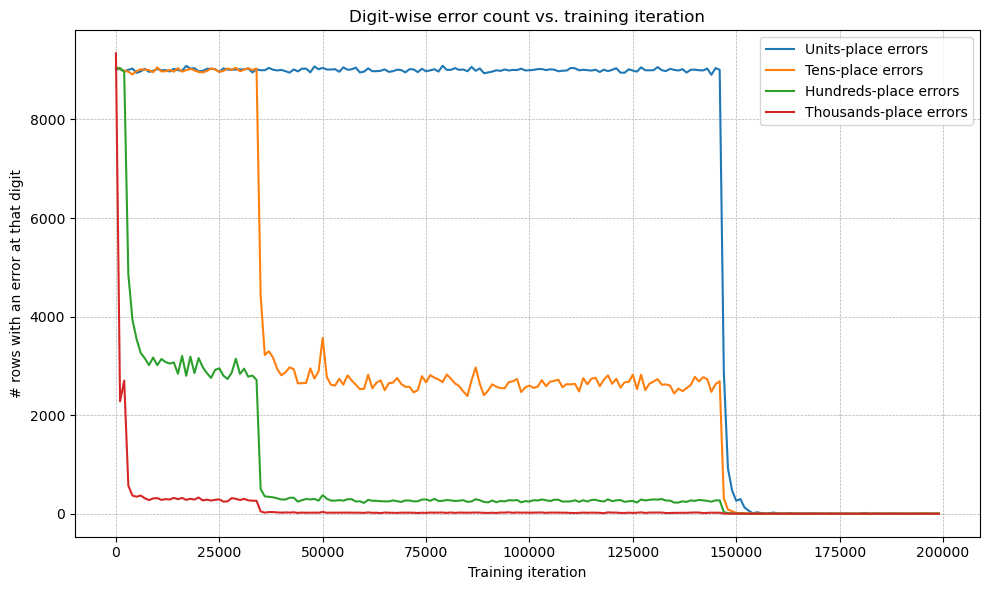

In [84]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 1) Load your data
df = pd.read_csv('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')

# 2) Identify the iteration‐columns
iter_cols = [c for c in df.columns if c.startswith('pred_iter_')]

# 3) Clean & convert to nullable integer, preserving any decimal point
for col in iter_cols:
    #  a) ensure strings
    #  b) strip everything except digits and dot
    cleaned = (
        df[col]
        .astype(str)
        .str.replace(r'[^0-9\.]', '', regex=True)
        .replace('', np.nan)           # empty → NaN
    )
    #  c) parse to float, then to pandas’ nullable Int64
    df[col] = (
        pd.to_numeric(cleaned, errors='coerce')
          .astype('Int64')
    )

# 4) Compute absolute errors
errors = df[iter_cols].sub(df['actual'], axis=0).abs()

# 5) Compute the average error at each iteration
avg_abs_err = errors.mean(axis=0)

# 6a) build err_map (same as above)
err_map = {}
for col, err in avg_abs_err.items():
    m = re.match(r'pred_iter_(\d+)$', col)
    if m:
        iteration = int(m.group(1))
        err_map[iteration] = err

# 6b) sort
iterations = sorted(err_map)
errors_sorted = [err_map[it] for it in iterations]

# 1) Choose your desired window
min_iter, max_iter = 10000, 34000

# 2) Filter both lists
iters_filt = []
errs_filt  = []
for it, err in zip(iterations, errors_sorted):
    if min_iter <= it <= max_iter:
        iters_filt.append(it)
        errs_filt.append(err)

# ─── NEW: print the iteration & its avg. error ───
print("Iteration\tAvg Abs Error")
for it, err in zip(iterations, errors_sorted):
    print(f"{it}\t\t{err:.4f}")


# 7) Plot with tweaks
fig, ax = plt.subplots(figsize=(10, 5))                   # wider figure
ax.plot(iters_filt, errs_filt, linestyle='-')

# Only horizontal grid lines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Throttle x‐ticks: show at most 10 evenly spaced labels
ax.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))

# Rotate the x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('Training Iterations')
ax.set_ylabel('Average Absolute Error')
ax.set_title('Avg. Absolute Error vs. Iterations')
plt.tight_layout()


plt.show()

import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# ─────────────────────── CONSTANTS ───────────────────────
CSV_PATH   = Path('/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv')   # <-- your single big file
STEP_SIZE  = 5
OFFSET     = 0                       # ← new: first iteration to plot
MAX_STEPS  = 400000
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ─────────────────────────────────────────────────────────────

df = pd.read_csv(CSV_PATH)

# find all pred_iter_* columns whose step = OFFSET + n*STEP_SIZE
pred_cols = []
for col in df.columns:
    m = re.fullmatch(PRED_REGEX, col)
    if not m:
        continue
    step = int(m.group(1))
    if step >= OFFSET and (step - OFFSET) % STEP_SIZE == 0 and step <= MAX_STEPS:
        pred_cols.append((step, col))
pred_cols.sort(key=lambda x: x[0])
# ─────────────────────────────────────────────────────────────

def digit_error_tally(actuals, preds) -> dict[str,int]:
    """
    Count digit‑wise mismatches between two sequences of numbers (or numeric strings).
    actuals, preds: pandas Series or other iterables of numeric or string values.
    Returns a dict mapping place names (units, tens, …) to error counts.
    """
    # 1) Convert actuals/preds to *strings* (defensive: blank on failure)
    str_actuals = []
    str_preds   = []
    for a, p in zip(actuals, preds):
        # actual
        try:
            str_actuals.append(str(int(a)))
        except Exception:
            str_actuals.append("")
        # prediction
        try:
            str_preds.append(str(int(p)))
        except Exception:
            str_preds.append("")

    # 2) Determine the widest number (so we know how many digit-places to check)
    max_width = max(max(len(s) for s in str_actuals),
                    max(len(s) for s in str_preds))

    # 3) Dynamically generate place names up to that width
    base_places = ["units", "tens", "hundreds", "thousands",
                   "ten-thousands", "hundred-thousands",
                   "millions", "ten-millions", "hundred-millions"]
    
    max_width = min(max_width, len(base_places))

    place_names = base_places[:max_width]

    # 4) Initialize counters
    counts = {place: 0 for place in place_names}

    # 5) Zero‑pad both sides and compare each digit
    for a_str, p_str in zip(str_actuals, str_preds):
        a_pad = a_str.zfill(max_width)
        p_pad = p_str.zfill(max_width)
        for i in range(max_width):
            if a_pad[i] != p_pad[i]:
                # position from the *right*
                place_idx = max_width - 1 - i
                counts[place_names[place_idx]] += 1

    return counts



# def digit_error_tally(actual, pred) -> dict[str, int]:
#     """Return dict with counts of errors by decimal place (units … thousands)."""
#     counts = {"units": 0, "tens": 0, "hundreds": 0, "thousands": 0}
#     for gold, guess in zip(actual, pred):
#         # defensive parsing – treat blanks / non-ints as all-digit errors
#         try:
#             g = str(int(gold)).zfill(4)
#             p = str(int(guess)).zfill(4)
#         except ValueError:
#             g = str(int(gold)).zfill(4)
#             p = "0000"
#         if g[-1] != p[-1]:
#             counts["units"] += 1
#         if g[-2] != p[-2]:
#             counts["tens"] += 1
#         if g[-3] != p[-3]:
#             counts["hundreds"] += 1
#         if g[-4] != p[-4]:
#             counts["thousands"] += 1

#     return counts


# ──────────────────── GATHER ERROR COUNTS ────────────────────

print(pred_cols)

iterations, units, tens, hundreds, thousands, ten_thousands, hundred_thousands, millions = [], [], [], [], [], [], [], []

for step, col in pred_cols:
    stats = digit_error_tally(df[ACTUAL_COL], df[col])
    iterations.append(step)
    units.append(stats["units"])
    tens.append(stats["tens"])
    hundreds.append(stats["hundreds"])
    thousands.append(stats["thousands"])
    # ten_thousands.append(stats["ten-thousands"])
    # hundred_thousands.append(stats.get("hundred-thousands", 0))  # optional, may not be present
    # millions.append(stats.get("millions", 0))  # optional, may not be present
    

# ──────────────────── PLOT ────────────────────
plt.figure(figsize=(10, 6))
plt.plot(iterations, units,     label="Units-place errors")
plt.plot(iterations, tens,      label="Tens-place errors")
plt.plot(iterations, hundreds,  label="Hundreds-place errors")
plt.plot(iterations, thousands, label="Thousands-place errors")
# plt.plot(iterations, ten_thousands, label="Ten-thousands-place errors")
# plt.plot(iterations, hundred_thousands, label="Hundred-thousands-place errors")
# plt.plot(iterations, millions,  label="Millions-place errors")

plt.title("Digit-wise error count vs. training iteration")
plt.xlabel("Training iteration")
plt.ylabel("# rows with an error at that digit")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/dp/6r_hlpr50lqcd7cw4178845m0000gn/T/ipykernel_44609/3491268155.py:12: DtypeWarning: Columns (4,6,9,10,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


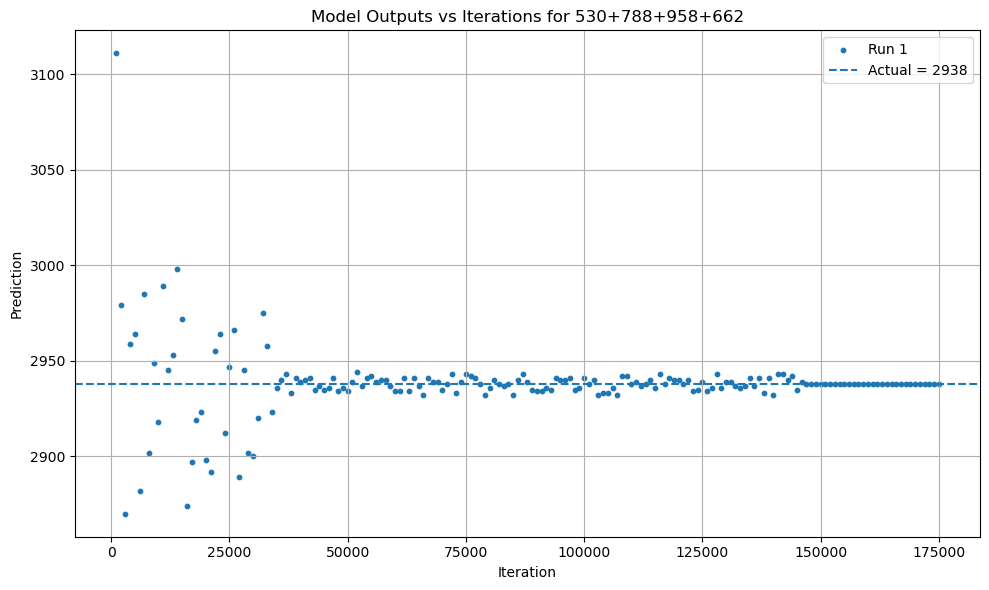

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_outputs(
    csv_path: str,
    example_operands: str,
    num_lines: int = 1,
    iter_min: int = 0,
    iter_max: int = None
):
    # Load data
    df = pd.read_csv(csv_path)
    
    # Filter the desired example(s)
    df_filtered = df[df['operands'] == example_operands].head(num_lines)
    if df_filtered.empty:
        raise ValueError(f"No rows found for operands '{example_operands}'")
    
    # Identify only the integer‐suffixed pred columns
    all_iter_cols = [
        col for col in df.columns 
        if col.startswith('pred_iter_') and col.replace('pred_iter_', '').isdigit()
    ]
    iterations = [int(col.replace('pred_iter_', '')) for col in all_iter_cols]
    
    # Apply iteration range
    if iter_max is None:
        iter_max = max(iterations)
    mask = [(iter_min <= it <= iter_max) for it in iterations]
    iter_cols = [c for c, m in zip(all_iter_cols, mask) if m]
    iters     = [it for it, m in zip(iterations,    mask) if m]
    
    plt.figure(figsize=(10, 6))
    
    for idx, (_, row) in enumerate(df_filtered.iterrows()):
        # Coerce to numeric, turning bad strings into NaN
        preds_series = pd.to_numeric(row[iter_cols], errors='coerce')
        # Drop any NaNs (and their corresponding iterations)
        valid = preds_series.notna()
        valid_iters = [it for it, v in zip(iters, valid) if v]
        valid_preds = preds_series[valid].tolist()
        
        plt.scatter(
            valid_iters,
            valid_preds,
            label=f'Run {idx+1}',
            marker='o',
            s=10
        )
    
    # Actual value line
    actual_value = df_filtered['actual'].iloc[0]
    plt.axhline(
        y=actual_value,
        linestyle='--',
        label=f'Actual = {actual_value}',
    )
    
    plt.title(f'Model Outputs vs Iterations for {example_operands}')
    plt.xlabel('Iteration')
    plt.ylabel('Prediction')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Example usage
if __name__ == "__main__":
    plot_model_outputs(
        csv_path='/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/4_operands_0_to_999_uniform_wo_padding/reverse_out_with_complete_stats_measure/4_operands_0_to_999_uniform_wo_padding_with_complete_stats_measure_reverse_2/test_reverse_results.csv',  # your CSV path
        example_operands="530+788+958+662",
        num_lines=1,
        iter_min=1000,
        iter_max=175000
    )


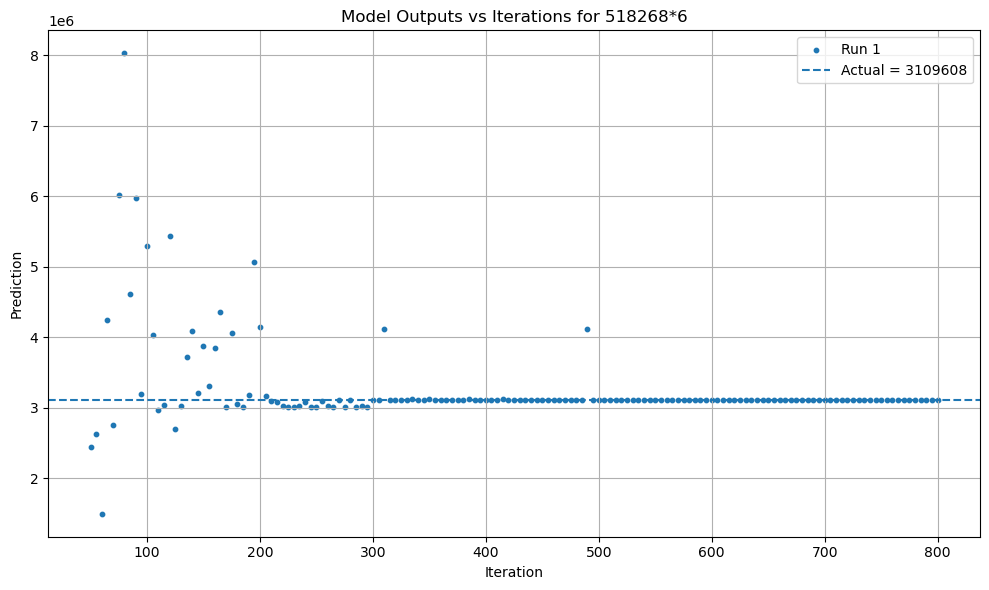

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_outputs(
    csv_path: str,
    example_operands: str,
    num_lines: int = 1,
    iter_min: int = 0,
    iter_max: int = None
):
    # Load data
    df = pd.read_csv(csv_path)
    
    # Filter the desired example(s)
    df_filtered = df[df['operands'] == example_operands].head(num_lines)
    if df_filtered.empty:
        raise ValueError(f"No rows found for operands '{example_operands}'")
    
    # Identify only the integer‐suffixed pred columns
    all_iter_cols = [
        col for col in df.columns 
        if col.startswith('pred_iter_') and col.replace('pred_iter_', '').isdigit()
    ]
    iterations = [int(col.replace('pred_iter_', '')) for col in all_iter_cols]
    
    # Apply iteration range
    if iter_max is None:
        iter_max = max(iterations)
    mask = [(iter_min <= it <= iter_max) for it in iterations]
    iter_cols = [c for c, m in zip(all_iter_cols, mask) if m]
    iters     = [it for it, m in zip(iterations,    mask) if m]
    
    plt.figure(figsize=(10, 6))
    
    for idx, (_, row) in enumerate(df_filtered.iterrows()):
        # Coerce to numeric, turning bad strings into NaN
        preds_series = pd.to_numeric(row[iter_cols], errors='coerce')
        # Drop any NaNs (and their corresponding iterations)
        valid = preds_series.notna()
        valid_iters = [it for it, v in zip(iters, valid) if v]
        valid_preds = preds_series[valid].tolist()
        
        plt.scatter(
            valid_iters,
            valid_preds,
            label=f'Run {idx+1}',
            marker='o',
            s=10
        )
    
    # Actual value line
    actual_value = df_filtered['actual'].iloc[0]
    plt.axhline(
        y=actual_value,
        linestyle='--',
        label=f'Actual = {actual_value}',
    )
    
    plt.title(f'Model Outputs vs Iterations for {example_operands}')
    plt.xlabel('Iteration')
    plt.ylabel('Prediction')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Example usage
if __name__ == "__main__":
    plot_model_outputs(
        csv_path='/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/0_to_six_digit_times_1_digit/reverse_out/0_to_six_digit_times_1_digit_reverse/0_to_six_digit_times_1_digit_bal_test_results.csv',  # your CSV path
        example_operands="518268*6",
        num_lines=1,
        iter_min=50,
        iter_max=800
    )


# MAE v.s. iter

Selected pred_iter	MAE	count_used
100	111.945260	2996
200	45.182304	2995
300	41.777518	2998
400	31.927285	2998
500	28.096667	3000
600	15.190397	2999
700	14.749333	3000
800	12.118333	3000
900	10.993333	3000
1000	10.842281	2999
1100	8.465000	3000
1200	4.511667	3000
1300	3.258000	3000
1400	3.673667	3000
1500	2.953000	3000
1600	2.979000	3000
1700	2.381667	3000
1800	2.967667	3000
1900	2.695667	3000
2000	3.401000	3000
2100	2.120667	3000
2200	2.520333	3000
2300	1.823000	3000
2400	2.456000	3000
2500	2.167000	3000
2600	1.181667	3000
2700	1.828333	3000
2800	1.150333	3000
2900	0.901000	3000
3000	0.829333	3000
3100	1.001667	3000
3200	0.676333	3000
3300	1.011667	3000
3400	0.707000	3000
3500	0.644000	3000
3600	0.633667	3000
3700	0.603667	3000
3800	0.546000	3000
3900	0.665333	3000
4000	0.830000	3000
4100	0.519667	3000
4200	0.420000	3000
4300	0.455333	3000
4400	0.396667	3000
4500	0.500333	3000
4600	0.396667	3000
4700	0.560667	3000
4800	0.538667	3000
4900	0.445000	3000
Saved plot to: mae_by_pred_iter.p

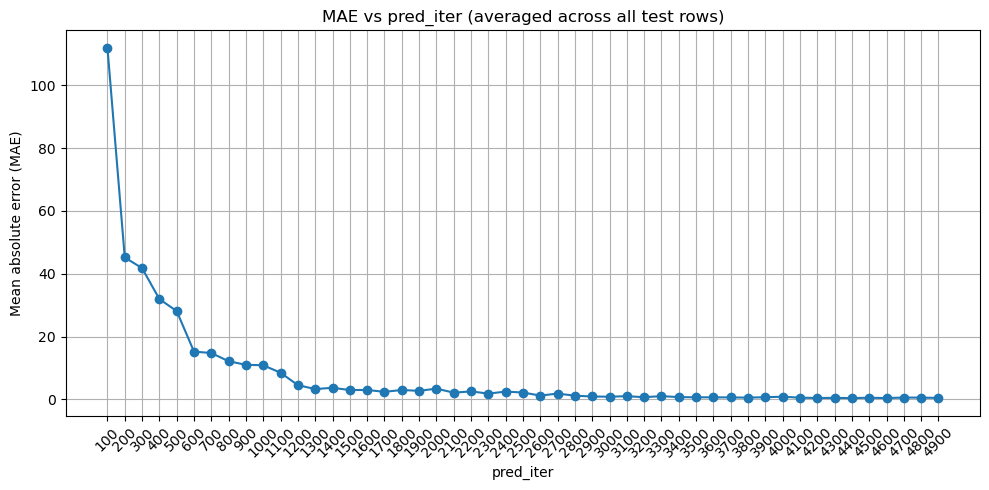

In [1]:
#!/usr/bin/env python3
"""
Compute and plot average absolute error (MAE) across all test rows for each
pred_iter column in a CSV file. Set the CSV path and x-range directly in the
script by editing CSV_PATH, MIN_ITER, MAX_ITER below.
"""
from pathlib import Path
import re
import ast
import operator as op

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------- USER CONFIG -----------------
CSV_PATH = '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/2_operands_0_to_999_subtraction/reverse_out/2_operands_0_to_999_subtraction_reverse/test_reverse_results.csv'

# Set the inclusive pred_iter range you want plotted.
# Examples:
#   MIN_ITER = 100; MAX_ITER = 400
#   MIN_ITER = None; MAX_ITER = 500  -> plot everything <= 500
#   MIN_ITER = None; MAX_ITER = None -> plot all pred_iter columns
MIN_ITER = 50
MAX_ITER = 5000
# ------------------------------------------------

# --- Safe evaluator that supports only integers, + and - ---
_allowed_binops = {ast.Add: op.add, ast.Sub: op.sub}
_allowed_unaryops = {ast.UAdd: op.pos, ast.USub: op.neg}


def _eval_ast(node):
    if isinstance(node, ast.Constant):  # python 3.8+
        if isinstance(node.value, (int,)):
            return node.value
        else:
            raise ValueError("Only integer constants allowed")
    if isinstance(node, ast.Num):  # older AST node
        return node.n
    if isinstance(node, ast.BinOp):
        if type(node.op) not in _allowed_binops:
            raise ValueError("Only + and - binary operations allowed")
        left = _eval_ast(node.left)
        right = _eval_ast(node.right)
        return _allowed_binops[type(node.op)](left, right)
    if isinstance(node, ast.UnaryOp):
        if type(node.op) not in _allowed_unaryops:
            raise ValueError("Only unary + and - allowed")
        operand = _eval_ast(node.operand)
        return _allowed_unaryops[type(node.op)](operand)
    raise ValueError("Unsupported expression")


def safe_eval_int(expr: str):
    """
    Safely evaluate a simple integer expression containing only + and -.
    """
    tree = ast.parse(expr, mode="eval")
    return int(_eval_ast(tree.body))


def parse_prediction_cell(cell: str):
    """
    Parse messy prediction cell into an integer prediction.

    Strategy:
      1. If empty/NaN -> return None
      2. Try safe_eval_int (handles '388-7', '790+4', '6-44' etc.)
      3. If safe eval fails, fallback to regex r'[-+]?\d+' and return the last match
    """
    if pd.isna(cell):
        return None
    s = str(cell).strip()
    if s == "":
        return None

    try:
        return safe_eval_int(s)
    except Exception:
        tokens = re.findall(r'[-+]?\d+', s)
        if not tokens:
            return None
        return int(tokens[-1])


def compute_mae_by_pred_iter(df: pd.DataFrame, actual_col: str = "actual"):
    """
    Return:
      pred_cols (sorted), x_iters (int suffixes), maes, counts
    """
    pred_cols = [c for c in df.columns if c.startswith("pred_iter")]
    if not pred_cols:
        raise ValueError("No pred_iter_* columns found in the CSV")

    def iter_key(colname):
        m = re.search(r"pred_iter[_-]?(\d+)", colname)
        if m:
            return int(m.group(1))
        return float('inf')

    pred_cols = sorted(pred_cols, key=iter_key)
    x_iters = [iter_key(c) for c in pred_cols]

    df_actuals = pd.to_numeric(df[actual_col], errors="coerce")

    maes = []
    counts = []
    for col in pred_cols:
        parsed = df[col].apply(parse_prediction_cell)
        valid_mask = (~df_actuals.isna()) & (~pd.isna(parsed))
        if valid_mask.sum() == 0:
            maes.append(np.nan)
            counts.append(0)
            continue
        abs_errors = (df_actuals[valid_mask] - parsed[valid_mask]).abs()
        maes.append(abs_errors.mean())
        counts.append(int(valid_mask.sum()))

    return pred_cols, x_iters, maes, counts


def filter_by_range(x_iters, maes, counts, min_iter=None, max_iter=None):
    """
    Keep only entries with min_iter <= x <= max_iter (inclusive).
    If min_iter or max_iter is None, treat as unbounded.
    """
    filtered_x = []
    filtered_mae = []
    filtered_counts = []
    for x, m, c in zip(x_iters, maes, counts):
        if x == float('inf'):
            continue
        if min_iter is not None and x < min_iter:
            continue
        if max_iter is not None and x > max_iter:
            continue
        filtered_x.append(x)
        filtered_mae.append(m)
        filtered_counts.append(c)
    return filtered_x, filtered_mae, filtered_counts


def plot_mae(filtered_x, filtered_mae, out_path="mae_by_pred_iter.png"):
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_x, filtered_mae, marker="o", linestyle="-")
    plt.xlabel("pred_iter")
    plt.ylabel("Mean absolute error (MAE)")
    plt.title("MAE vs pred_iter (averaged across all test rows)")
    plt.grid(True)
    plt.xticks(filtered_x, [str(x) for x in filtered_x], rotation=45)
    plt.tight_layout()
    plt.savefig(out_path)
    print(f"Saved plot to: {out_path}")
    plt.show()


def main():
    csv_path = Path(CSV_PATH)
    if not csv_path.exists():
        raise FileNotFoundError(f"{csv_path} not found. Edit CSV_PATH at top of script.")

    df = pd.read_csv(csv_path, sep=None, engine="python")
    df.columns = [c.strip() for c in df.columns]

    if "actual" not in df.columns:
        raise ValueError("CSV must contain an 'actual' column with ground-truth integers.")

    pred_cols, x_iters, maes, counts = compute_mae_by_pred_iter(df, actual_col="actual")

    filtered_x, filtered_mae, filtered_counts = filter_by_range(
        x_iters, maes, counts, min_iter=MIN_ITER, max_iter=MAX_ITER
    )

    if not filtered_x:
        print("No pred_iter columns fall into the provided range. Nothing to plot.")
        print("Available pred_iter values:", x_iters)
        return

    # Print the selected results
    print("Selected pred_iter\tMAE\tcount_used")
    for x, m, c in zip(filtered_x, filtered_mae, filtered_counts):
        print(f"{x}\t{(m if not np.isnan(m) else float('nan')):.6f}\t{c}")

    plot_mae(filtered_x, filtered_mae, out_path="mae_by_pred_iter.png")


if __name__ == "__main__":
    main()


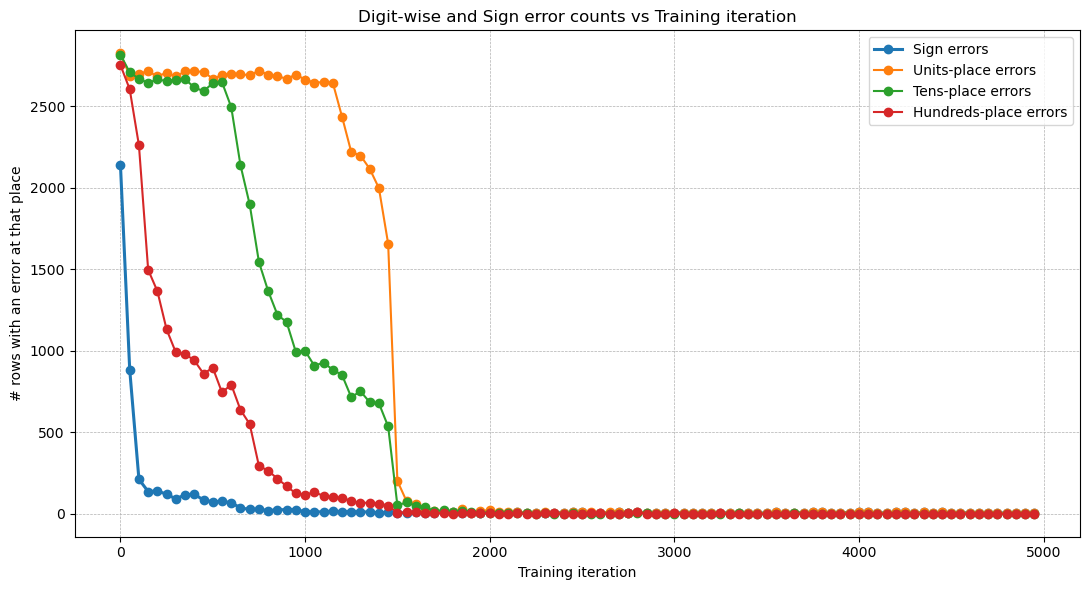

In [3]:
#!/usr/bin/env python3
"""
Digit-wise error plot with an additional "sign-place" line.

Edit CSV_PATH, STEP_SIZE, OFFSET, MIN_ITER, MAX_ITER below and run.
"""
from pathlib import Path
import re
import ast
import operator as op
from typing import Iterable, List, Dict, Optional

import pandas as pd
import matplotlib.pyplot as plt

# ---------------- USER CONFIG ----------------
CSV_PATH  = Path(
    '/Users/perfectpeter/Library/CloudStorage/GoogleDrive-llmfunexperiment@gmail.com/My Drive/addition/results/2_operands_0_to_999_subtraction_balanced_digit/reverse_out/2_operands_0_to_999_subtraction_balanced_digit_reverse_1/test_reverse_results.csv'
)
STEP_SIZE = 5
OFFSET    = 0
MIN_ITER  = None   # inclusive lower bound on pred_iter numeric suffix, or None
MAX_ITER  = None   # inclusive upper bound on pred_iter numeric suffix, or None
ACTUAL_COL = "actual"
PRED_REGEX = r"pred_iter_(\d+)"
# ----------------------------------------------


# --- Safe mini-evaluator (only integers, + and -) ---
_allowed_binops = {ast.Add: op.add, ast.Sub: op.sub}
_allowed_unaryops = {ast.UAdd: op.pos, ast.USub: op.neg}


def _eval_ast(node):
    if isinstance(node, ast.Constant):  # python 3.8+
        if isinstance(node.value, int):
            return node.value
        raise ValueError("Only integer constants allowed")
    if isinstance(node, ast.Num):
        return node.n
    if isinstance(node, ast.BinOp):
        if type(node.op) not in _allowed_binops:
            raise ValueError("Only + and - supported")
        return _allowed_binops[type(node.op)](_eval_ast(node.left), _eval_ast(node.right))
    if isinstance(node, ast.UnaryOp):
        if type(node.op) not in _allowed_unaryops:
            raise ValueError("Only unary + and - supported")
        return _allowed_unaryops[type(node.op)](_eval_ast(node.operand))
    raise ValueError("Unsupported AST node")


def safe_eval_int(expr: str) -> int:
    """Safely evaluate a simple integer expression containing only + and -."""
    tree = ast.parse(expr, mode="eval")
    return int(_eval_ast(tree.body))


def parse_prediction_cell(cell) -> Optional[int]:
    """
    Parse messy prediction cell into integer, or return None if cannot parse.
    Strategy:
      1. If NaN/empty -> None
      2. Try safe_eval_int (handles '388-7', '790+4', '6-44' etc.)
      3. Fallback: regex find ints and return last token (change to [0] for first)
    """
    if pd.isna(cell):
        return None
    s = str(cell).strip()
    if s == "":
        return None
    try:
        return safe_eval_int(s)
    except Exception:
        tokens = re.findall(r"[-+]?\d+", s)
        if not tokens:
            return None
        return int(tokens[-1])


# ---------------- Digit error tally (includes sign place) ----------------
def digit_error_tally(actuals: Iterable, preds: Iterable, max_places_hint: Optional[int] = None) -> Dict[str, int]:
    """
    Count sign errors + digit-wise mismatches.
    - actuals: iterable of ints (or values convertible to int)
    - preds: iterable of ints or None (parsed predictions)
    Returns a dict with keys: "sign", "units", "tens", "hundreds", ...
    """
    # Convert actuals to ints (or None if missing). Predictions should already be parsed ints or None.
    acts: List[Optional[int]] = []
    ps: List[Optional[int]] = []
    for a, p in zip(actuals, preds):
        try:
            acts.append(int(a))
        except Exception:
            acts.append(None)
        if p is None:
            ps.append(None)
        else:
            try:
                ps.append(int(p))
            except Exception:
                ps.append(None)

    # Determine maximum digit width (based primarily on actuals so we evaluate relevant places)
    abs_lengths = [len(str(abs(x))) for x in acts if x is not None]
    # also consider preds if they exist and are larger than actuals
    abs_lengths += [len(str(abs(x))) for x in ps if x is not None]
    max_width = max(abs_lengths) if abs_lengths else 1
    if max_places_hint:
        max_width = max(max_width, max_places_hint)

    # limit to some reasonable labeling size
    # base_places = ["units", "tens", "hundreds", "thousands", "ten-thousands", "hundred-thousands", "millions"]
    base_places = ["units", "tens", "hundreds"]
    max_width = min(max_width, len(base_places))
    place_names = base_places[:max_width]

    # initialize counters, include sign
    counts = {"sign": 0}
    for name in place_names:
        counts[name] = 0

    # iterate rows
    for a_val, p_val in zip(acts, ps):
        # if actual missing, skip the row (can't evaluate)
        if a_val is None:
            continue

        # sign check: if prediction missing -> treat as sign error
        if p_val is None:
            counts["sign"] += 1
            # treat as digit-errors for all places (prediction unknown => counted as wrong)
            for name in place_names:
                counts[name] += 1
            continue

        # both present -> sign differ?
        actual_neg = a_val < 0
        pred_neg = p_val < 0
        if actual_neg != pred_neg:
            counts["sign"] += 1

        # digit-wise: compare absolute values, zero-pad on the left to max_width
        a_digits = str(abs(a_val)).zfill(max_width)
        p_digits = str(abs(p_val)).zfill(max_width)
        # compare left-to-right (but place label mapping uses right-to-left)
        for i in range(max_width):
            # position from right: place_idx
            place_idx = max_width - 1 - i
            place_name = place_names[place_idx]
            if a_digits[i] != p_digits[i]:
                counts[place_name] += 1

    return counts


# ---------------- Main processing ----------------
def main():
    if not CSV_PATH.exists():
        raise FileNotFoundError(f"{CSV_PATH} not found. Edit CSV_PATH at top of file.")

    df = pd.read_csv(CSV_PATH, sep=None, engine="python")
    df.columns = [c.strip() for c in df.columns]

    if ACTUAL_COL not in df.columns:
        raise ValueError(f"CSV must contain an '{ACTUAL_COL}' column.")

    # collect pred_iter columns satisfying STEP/OFFSET and optional MIN/MAX bounds
    pred_cols = []
    for col in df.columns:
        m = re.fullmatch(PRED_REGEX, col)
        if not m:
            continue
        step = int(m.group(1))
        if step < OFFSET:
            continue
        if (step - OFFSET) % STEP_SIZE != 0:
            continue
        if (MIN_ITER is not None and step < MIN_ITER) or (MAX_ITER is not None and step > MAX_ITER):
            continue
        pred_cols.append((step, col))
    pred_cols.sort(key=lambda x: x[0])

    if not pred_cols:
        print("No pred_iter columns matched selection. Check STEP_SIZE/OFFSET/MIN_ITER/MAX_ITER/PRED_REGEX.")
        return

    iterations = []
    sign_counts = []
    # dynamic place lists prepared after first tally (we want consistent ordering)
    place_order: List[str] = []
    place_counts_map: Dict[str, List[int]] = {}

    # For performance, parse columns lazily and reuse parsing
    for step, col in pred_cols:
        # parse predictions for this column
        parsed_preds = df[col].apply(parse_prediction_cell)
        counts = digit_error_tally(df[ACTUAL_COL], parsed_preds)
        iterations.append(step)
        sign_counts.append(counts["sign"])

        # initialize place_order map if first time
        if not place_order:
            # collect place keys except "sign" in descending order we want to plot
            place_order = [k for k in counts.keys() if k != "sign"]
            # ensure a consistent order: units, tens, hundreds, ... (already produced in that order)
            for pn in place_order:
                place_counts_map[pn] = []
        # append counts for each place in place_order
        for pn in place_order:
            place_counts_map[pn].append(counts.get(pn, 0))

    # ---------- Plot ----------
    plt.figure(figsize=(11, 6))
    # plot sign first with bolder style
    plt.plot(iterations, sign_counts, label="Sign errors", linewidth=2.2, marker="o")

    # plot each digit place (units, tens, hundreds, ...)
    for pn in place_order:
        plt.plot(iterations, place_counts_map[pn], label=f"{pn.capitalize()}-place errors", marker="o", linestyle="-")

    plt.title("Digit-wise and Sign error counts vs Training iteration")
    plt.xlabel("Training iteration")
    plt.ylabel("# rows with an error at that place")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
